### Create ML Model

#### Author: Lauren Thomas
#### Created: 29/07/2021
#### Last updated: 07/08/2021

###### File description: This file creates the ML models, using the features extracted in the other scripts


In [4]:
import pickle
import sklearn
import warnings


import geopandas as gp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from os import sep
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from tabulate import tabulate
from scipy.stats import sem
from sklearn.metrics import recall_score, precision_score, f1_score


warnings.filterwarnings("ignore", category=FutureWarning)


In [5]:
cwd = f'C:{sep}Users{sep}ltswe{sep}Dropbox{sep}Oxford{sep}Thesis'
data_dir = "D:"

In [7]:
# Begin by creating baseline model, using only socioeconomic features

# Bring in labels data
labels_gdf = pickle.load(open(f'{data_dir}{sep}pickle{sep}labels_gdf.pickle', 'rb'))
labels_gdf = labels_gdf.rename(columns={'fips_code': 'LocationCT'})
labels_gdf = labels_gdf[['LocationCT', 'geometry', 'eligible_gentrify_alt', 'gentrification_alt']]

# Bring in non-Twitter features
non_twitter_features = pickle.load(open(f'{data_dir}{sep}pickle{sep}non_twitter_features.pickle', 'rb'))

In [8]:
labels_gdf.eligible_gentrify_alt.value_counts()

0.0    1167
1.0     931
Name: eligible_gentrify_alt, dtype: int64

In [9]:
labels_gdf.gentrification_alt.value_counts()

0.0    1826
1.0     273
Name: gentrification_alt, dtype: int64

In [10]:
# Bring in Twitter features for train/test/val
tweets_features_train_old = pickle.load(open(f'{data_dir}{sep}pickle{sep}tweets_features_train.pickle', 'rb'))
tweets_features_test = pickle.load(open(f'{data_dir}{sep}pickle{sep}tweets_features_test.pickle', 'rb'))
tweets_features_val = pickle.load(open(f'{data_dir}{sep}pickle{sep}tweets_features_val.pickle', 'rb'))

In [11]:
# Combine train & val sets
tweets_features_train = tweets_features_train_old.append(tweets_features_val).reset_index(drop=True)

In [12]:
# Bring in topic distribution features
topic_dist_avg = pickle.load(open(f'{data_dir}{sep}pickle{sep}topic_dist_avg.pickle', 'rb'))
topic_dist_temp = pickle.load(open(f'{data_dir}{sep}pickle{sep}topic_dist_temp.pickle', 'rb'))
topic_dist_max = pickle.load(open(f'{data_dir}{sep}pickle{sep}topic_dist_max.pickle', 'rb'))


In [13]:
# Create dataframe for train/test/val by merging
train_df_full = labels_gdf.merge(non_twitter_features.merge(tweets_features_train.merge(topic_dist_avg, on='LocationCT'), on='LocationCT'), on='LocationCT')
test_df_full = labels_gdf.merge(non_twitter_features.merge(tweets_features_test.merge(topic_dist_avg, on='LocationCT'), on='LocationCT'), on='LocationCT')

# Create sep dataframe with temporal features (since there are so many columns that it gets confusing)
train_df_temp = labels_gdf.merge(non_twitter_features.merge(tweets_features_train.merge(topic_dist_temp, on='LocationCT'), on='LocationCT'), on='LocationCT')
test_df_temp = labels_gdf.merge(non_twitter_features.merge(tweets_features_test.merge(topic_dist_temp, on='LocationCT'), on='LocationCT'), on='LocationCT')

# Create sep dataframe with max topic dist
train_df_max = labels_gdf.merge(non_twitter_features.merge(tweets_features_train.merge(topic_dist_max, on='LocationCT'), on='LocationCT'), on='LocationCT')
test_df_max = labels_gdf.merge(non_twitter_features.merge(tweets_features_test.merge(topic_dist_max, on='LocationCT'), on='LocationCT'), on='LocationCT')


In [14]:
# Get rid of non eligible tracts
train_df = train_df_full[train_df_full['eligible_gentrify'] == 1].reset_index(drop=True)
test_df = test_df_full[test_df_full['eligible_gentrify'] == 1].reset_index(drop=True)

train_df_temp = train_df_temp[train_df_temp['eligible_gentrify'] == 1].reset_index(drop=True)
test_df_temp = test_df_temp[test_df_temp['eligible_gentrify'] == 1].reset_index(drop=True)

train_df_max = train_df_max[train_df_max['eligible_gentrify'] == 1].reset_index(drop=True)
test_df_max = test_df_max[test_df_max['eligible_gentrify'] == 1].reset_index(drop=True)


In [15]:
train_df.gentrification.value_counts()

0    260
1     82
Name: gentrification, dtype: int64

In [16]:
test_df.gentrification.value_counts()

0    48
1    15
Name: gentrification, dtype: int64

In [17]:
82/(260+82)

0.23976608187134502

In [18]:
15/(48+15)

0.23809523809523808

In [19]:
# Create correlational matrices
# Create dfs with just relevant features
all_socio_features = ['%_black_0610', '%_white_0610', '%_bachelors_0610', '%_nonwhite_0610',
       '%_hhrent_0610', '%_li_0610', 'med_hh_income_0610', 'med_rent_0610',
       'med_home_value_0610', '%_unemployed_0610', 'gentrification']
nontwitter_features = ['total_comm_trend', 'total_res_trend', 'total_res_vacant_ST_trend',
       'total_comm_vacant_ST_trend', 'total_res_vacant_LT_trend',
       'total_comm_vacant_LT_trend', 'crime_0610_trend', 'crime_1113_trend',
       'fel_0610_trend', 'fel_1113_trend', 'crime_pc_0610', 'crime_pc_1113',
       'fel_pc_0610', 'fel_pc_1113', 'noise_1113_trend', 'fhv_1113_trend',
       'bike_1113_trend', 'gentrification']
twitter_features1 = ['%_english_tweets_trend', 'tweets_count_trend',
       'first_tweet_count', 'last_tweet_count', 'avg_tweet_count', 'topic0',
       'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7',
       'topic8', 'topic9', 'topic10', 'topic11', 'gentrification']
twitter_features2 = ['topic12', 'topic13',
       'topic14', 'topic15', 'topic16', 'topic17', 'topic18', 'topic19',
       'topic20', 'topic21', 'topic22', 'topic23', 'topic24', 'topic25',
       'topic26', 'topic27', 'topic28', 'gentrification']
twitter_features3 = [ 'topic29', 'topic30', 'topic31',
       'topic32', 'topic33', 'topic34', 'topic35', 'topic36', 'topic37',
       'topic38', 'topic39', 'topic40', 'topic41', 'topic42', 'topic43',
       'topic44', 'gentrification']
ym_list = [year+"-"+month for year in ['2011', '2012', '2013'] for month in ['01', '02', '03', '04', '05', '06', '07', '08',
                                                                            '09', '10', '11', '12']]
topic_temporal_list = ['topic'+str(i)+"_"+ym for i in range(45) for ym in ym_list]
topic_temp_features = ['%_english_tweets_trend', 'tweets_count_trend',
       'first_tweet_count', 'last_tweet_count', 'avg_tweet_count'] + topic_temporal_list + ['gentrification']

socio_df = train_df[all_socio_features]
nontwitter_df = train_df[nontwitter_features]
avg_twitter_df1 = train_df[twitter_features1]
avg_twitter_df2 = train_df[twitter_features2]
avg_twitter_df3 = train_df[twitter_features3]


max_twitter_df1 = train_df_max[twitter_features1]
max_twitter_df2 = train_df[twitter_features2]
max_twitter_df3 = train_df[twitter_features3]



temporal_twitter_df = train_df_temp[topic_temp_features]

In [20]:
socio_df.columns = ['Percent Black', 'Percent White', 'Percent College Educated', 'Percent Nonwhite', 'Percent of Households Renting',
                   'Percent Low Income', 'Median Household Income', "Median Rent", 'Median Home Value', 'Percent Unemployed', 'Tract Gentrified']
nontwitter_df.columns = ['Trend in Commercial Addresses', 'Trend in Residential Addresses', 'Trend in ST Vacant Residential Addresses',
       'Trend in ST Vacant Commercial Addresses', 'Trend in Vacant LT Residential Addresses',
       'Trend in Vacant LT Commercial Addresses', 'Crime Trendline 06-10', 'Crime Trendline 11-13',
       'Felony Trendline 06-10', 'Felony Trendline 11-13', 'Crime PC 06-10', 'Crime PC 11-13',
       'Felonies PC 06-10', 'Felonies PC 11-13', 'Noise Reports Trend 11-13', 'For-Hire Vehicle Complaints Trend 11-13',
       'Bike Rack Complaints Trend 11-13', 'Tract Gentrified']
avg_topic_names1 = ['Avg Topic ' + str(i) + " Distribution" for i in range(12)]
avg_topic_names2 = ['Avg Topic ' + str(i) + " Distribution" for i in range(12,29)]
avg_topic_names3 = ['Avg Topic ' + str(i) + " Distribution" for i in range(29,45)]


max_topic_names1 = ['Max Topic ' + str(i) + " Distribution" for i in range(12)]
max_topic_names2 = ['Max Topic ' + str(i) + " Distribution" for i in range(12,29)]
max_topic_names3 = ['Avg Topic ' + str(i) + " Distribution" for i in range(29,45)]


temporal_topic_names = ['Topic '+str(i)+"Distribution: "+ym for i in range(45) for ym in ym_list]


avg_twitter_df1.columns = ['Trend in Percentage of English-Lang Tweets', 'Trend in Total Tweet Count',
       'Tweet Count-Beginning', 'Tweet Count-End', 'Average Tweet Count'] + avg_topic_names1 + ['Tract Gentrified']

avg_twitter_df2.columns = avg_topic_names2 + ['Tract Gentrified']
avg_twitter_df3.columns = avg_topic_names3 + ['Tract Gentrified']


max_twitter_df1.columns = ['Trend in Percentage of English-Lang Tweets', 'Trend in Total Tweet Count',
       'Tweet Count-Beginning', 'Tweet Count-End', 'Average Tweet Count'] + max_topic_names1 + ['Tract Gentrified']

max_twitter_df2.columns = max_topic_names2 + ['Tract Gentrified']
max_twitter_df3.columns = max_topic_names3 + ['Tract Gentrified']


temporal_twitter_df.columns = ['Trend in Percentage of English-Lang Tweets', 'Trend in Total Tweet Count',
       'Tweet Count-Beginning', 'Tweet Count-End', 'Average Tweet Count'] + temporal_topic_names + ['Tract Gentrified']



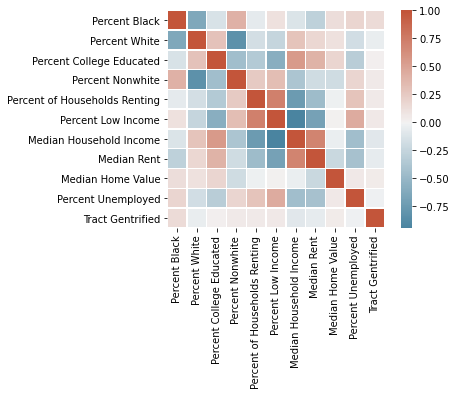

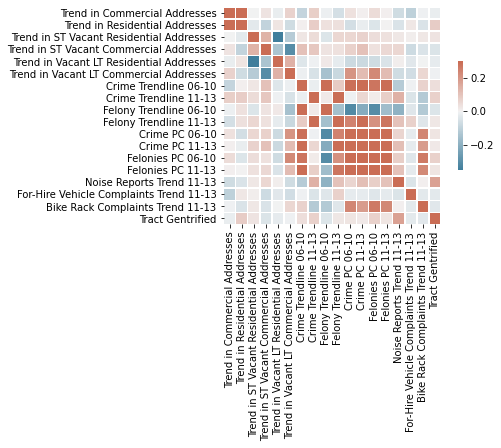

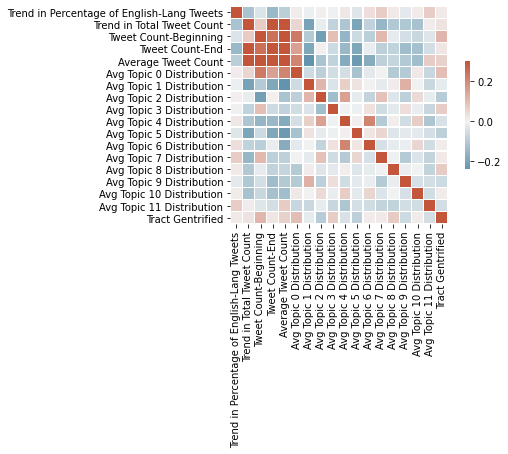

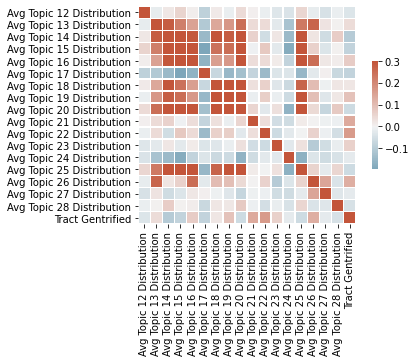

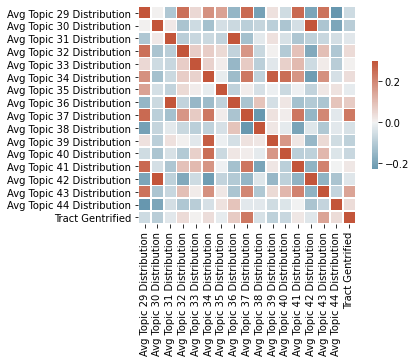

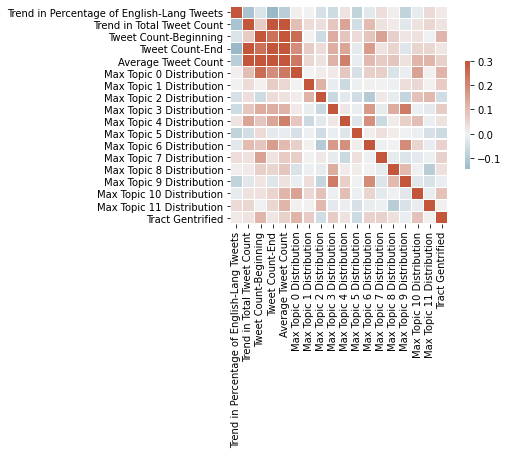

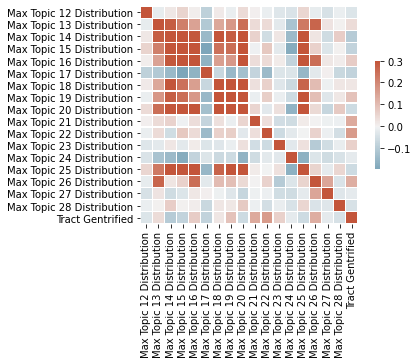

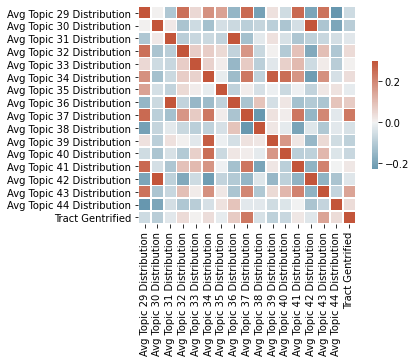

In [16]:
def create_corr_heatmap(df, save_as):
    df_corr = df.corr()
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    if save_as == 'socio_corr':
        sns.heatmap(df_corr, cmap=cmap, center=0, square=True,
        linewidths=0.5)
    else:
        sns.heatmap(df_corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.savefig(f'{cwd}{sep}figures{sep}heatmaps{sep}{save_as}_heatmap.jpg', bbox_inches='tight')
    plt.show()
    # Save corr file to LaTeX
    headers = df_corr.columns
    table_file = open(f"{cwd}{sep}tex{sep}tables{sep}{save_as}.tex","w")
    table = tabulate(df_corr, headers, tablefmt="latex")
    table_lines = [line for line in table]
    table_file.writelines(table_lines)
    table_file.close()

    return df_corr
    
socio_corr = create_corr_heatmap(socio_df, 'socio_corr')
nontwitter_corr = create_corr_heatmap(nontwitter_df, 'nontwitter_corr')

avg_twitter_corr1 = create_corr_heatmap(avg_twitter_df1, 'avg_twitter_corr1')
avg_twitter_corr2 = create_corr_heatmap(avg_twitter_df2, 'avg_twitter_corr2')
avg_twitter_corr3 = create_corr_heatmap(avg_twitter_df3, 'avg_twitter_corr3')


max_twitter_corr1 = create_corr_heatmap(max_twitter_df1, 'max_twitter_corr1')
max_twitter_corr2 = create_corr_heatmap(max_twitter_df2, 'max_twitter_corr2')
max_twitter_corr3 = create_corr_heatmap(max_twitter_df3, 'max_twitter_corr3')

In [17]:
train_df_alt = train_df_full[train_df_full['eligible_gentrify_alt'] == 1].reset_index(drop=True)
test_df_alt = test_df_full[test_df_full['eligible_gentrify_alt'] == 1].reset_index(drop=True)


In [18]:
train_df.gentrification.value_counts()

0    260
1     82
Name: gentrification, dtype: int64

In [19]:
train_df_alt.gentrification_alt.value_counts()

0.0    558
1.0    231
Name: gentrification_alt, dtype: int64

In [21]:
# Create a function that takes in the training set and returns a resampled dataframe
def upsample_train_df(train_df):
# Separate majority and minority classes (non-gentrified and gentrified)
    df_majority = train_df[train_df.gentrification==0]
    df_minority = train_df[train_df.gentrification==1]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    return df_upsampled

In [22]:
# Upsample train df
train_df_upsampled = upsample_train_df(train_df).reset_index(drop=True)
train_df_upsampled_max = upsample_train_df(train_df_max).reset_index(drop=True)
train_df_upsampled_temp = upsample_train_df(train_df_temp).reset_index(drop=True)

In [22]:
train_df_upsampled_alt = upsample_train_df(train_df_alt).reset_index(drop=True)

In [23]:
train_df_upsampled.gentrification.value_counts()

1    260
0    260
Name: gentrification, dtype: int64

In [24]:
train_df_upsampled_alt.gentrification.value_counts()

1    707
0    707
Name: gentrification, dtype: int64

In [23]:
#Form np arrays of labels and features.
train_labels = np.array(train_df.pop('gentrification'))
train_labels_upsampled = np.array(train_df_upsampled.pop('gentrification'))

test_labels = np.array(test_df.pop('gentrification'))

In [109]:
#Form np arrays of labels and features.
train_labels_alt = np.array(train_df_alt.pop('gentrification'))
train_labels_alt_upsampled = np.array(train_df_upsampled_alt.pop('gentrification'))

test_labels_alt = np.array(test_df_alt.pop('gentrification'))

In [24]:
# Create a function that takes in train df/test df/val df and normalizes the features so they're ready for a ML model
def normalize_features(train_df, test_df, report_shape = False):
    train_features = np.array(train_df)
    test_features = np.array(test_df)
    
    # Normalize features (using whole dataset)
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    test_features = scaler.transform(test_features)

    if report_shape == True:
        print('Training labels shape:', train_labels.shape)
        print('Test labels shape:', test_labels.shape)

        print('Training features shape:', train_features.shape)
        print('Test features shape:', test_features.shape)
    
    return train_features,test_features

In [25]:
# Create function that takes features created in previous function and fits a log reg/RF model to them.
# Uses cross-validation to find the AUC score
def fit_log_model(train_features, test_features, train_labels, test_labels, report_scores = True,weights= {0:1.0, 1:1.0}):
    
    log_reg_model = LogisticRegression(class_weight=weights)

    # Use cross validation to find AUC score
    scores = cross_val_score(log_reg_model, train_features, train_labels, cv=10, scoring = 'roc_auc')
    if report_scores == True:
        print('Log Reg AUROC Scores using tenfold Cross Validation on Training Set \n')
        print('Mean: ', round(scores.mean(),4), 'Standard Error: ', round(sem(scores),3))    
    return log_reg_model, scores

    

In [26]:
# Create function that fits RF model 
def fit_rf_model(train_features, test_features, train_labels, test_labels, n_estimators = 100, random_state=None, report_scores = True):
    rand_for_model = RandomForestClassifier(n_estimators = n_estimators, random_state = random_state)
    scores = cross_val_score(rand_for_model, train_features, train_labels, cv=10, scoring = 'roc_auc')
    if report_scores == True:
        print('Tenfold Cross Validation on Training Set -- AUCROC Score Mean: ', round(scores.mean(),4), 
              "\n SE: ", round(sem(scores),3))
    
    return rand_for_model, scores


In [27]:
# Create function that returns a train, train upsampled, test and val set given a list of features
def return_df(list_of_features, full_train_df, full_train_df_upsampled, full_test_df):
    new_train_df = full_train_df[list_of_features].fillna(0)
    new_upsampled_train_df = full_train_df_upsampled[list_of_features].fillna(0)
    new_test_df = full_test_df[list_of_features].fillna(0)
    
    return new_train_df, new_upsampled_train_df, new_test_df

In [28]:
# Fit log reg model with updated class weights. Create function that runs through various weights and picks
# the one with the best AUC score
def tune_weights(train_features, test_features, train_labels, test_labels, weights_list):
    weights_list = weights_list
    auc_scores = []
    for weight in weights_list:
        weights= {0:1.0, 1:weight}
        # Train the model using cross validation, but make sure to turn report features off.
        # fit log model return a list of scores from cross-validation. Use mean as auc score
        log_reg, scores_list = fit_log_model(train_features,test_features, 
                                                   train_labels, test_labels, report_scores=False,weights=weights)
        auc = scores_list.mean()
        auc_scores.append(auc)
    max_auc_idx = auc_scores.index(max(auc_scores))
    best_weight = weights_list[max_auc_idx]
    print(f'The weight ratio with the highest AUC score is 0:1.0, 1:{round(best_weight, 7)}, with an AUC score of {round(max(auc_scores),7)}')
    return best_weight
        

In [74]:
# Create function that takes in a dataframe with all the relevant features & using cross-validation,
# compares the various potential models to find the one with the best AUROC
def tune_log_reg(train_df, train_df_upsampled, test_df, train_labels, train_labels_upsampled, boxplot_title, save_as):
    # Create empty list for all scores/labels (will be turned into df and then boxplot later)
    scores_list = []
    labels_list = []
    
    # Normalize/prepare features
    train_features, test_features = normalize_features(train_df, test_df)
    
    # Normalize/prepare upsampled features. Note that b/c we're normalizing based on train_features, even tho test/val are the same,
    # they need to be normalized separately from the above
    train_features_up, test_features_up = normalize_features(train_df_upsampled,test_df)
    print('\n')
    
    # Return basic log reg and AUC ROC score
    print('\nBasic Logistic Regression Model')
    log_reg, basic_scores = fit_log_model(train_features,test_features, train_labels, test_labels)
    # Find mean and SE
    mean_basic = basic_scores.mean()
    std_basic = sem(basic_scores)
    report_basic = str(round(mean_basic,4))+f" ({round(std_basic,3)})"
    # Add to list
    scores_list.extend(basic_scores)
    labels_list.extend(['Basic' for score in basic_scores])

    # Compute weighted models. Start with computed class weight.
    weighting = compute_class_weight('balanced', [0,1], train_labels)

    weights = {0:weighting[0], 1:weighting[1]}
    weights_str = {0:round(weighting[0],4), 1:round(weighting[1],4)}

    print(f'\nWeighted Logistic Regression Model with weights of {weights_str}')
    weighted_log_reg, weighted_scores = fit_log_model(train_features,test_features, 
                                           train_labels, test_labels,
                                          weights = weights)
    # Find mean and SE
    mean_weighted = weighted_scores.mean()
    std_weighted = sem(weighted_scores)
    
    report_weighted = str(round(mean_weighted,4))+f" ({round(std_weighted,3)})"
    scores_list.extend(weighted_scores)
    labels_list.extend(['Weights' for score in weighted_scores])
    
    # Use tune weights to run through list of weights to find the best one
    # Since we know that the ratio is *about* 1 to 3, run through increments near this number
    weights_list = np.arange(2.5, 3.5, 0.01).tolist()
    best_weight = tune_weights(train_features, test_features, train_labels, test_labels, weights_list)
    
    # Compute model with this weight
    tuned_weights = {0:1.0, 1:best_weight}
    tuned_weights_str = {0:1.0, 1:round(best_weight,4)}
    print(f'\nWeighted Logistic Regression Model with Tuned Weights of {tuned_weights_str}')
    tuned_log_reg, tuned_scores = fit_log_model(train_features,test_features, 
                                           train_labels, test_labels,
                                          weights = tuned_weights)
    scores_list.extend(tuned_scores)
    labels_list.extend(['Tuned Weights' for score in tuned_scores])
    
    # Find mean and SE
    mean_tuned = tuned_scores.mean()
    std_tuned = sem(tuned_scores)
    report_tuned = str(round(mean_tuned,4))+f" ({round(std_tuned,3)})"
    
    # Find best upsampled weight
    up_weights_list = np.arange(0.5,1.5,0.01).tolist()
    best_weight_up = tune_weights(train_features_up, test_features, train_labels_upsampled, test_labels, up_weights_list)
    tuned_weights = {0:1.0, 1:best_weight_up}
    tuned_weights_str = {0:1.0, 1:round(best_weight_up,4)}
    
    # Compute models with upsampled dataframes
    print('\nLogistic Regression Model with Upsampled Training Data')
    resampled_log_reg, resampled_scores= fit_log_model(train_features_up,test_features_up,  
                                                    train_labels_upsampled, test_labels)
    scores_list.extend(resampled_scores)
    labels_list.extend(['Upsample' for score in resampled_scores])
    
    # Find mean and SE
    mean_resampled = resampled_scores.mean()
    std_resampled = sem(resampled_scores)
    report_resampled = str(round(mean_resampled,4))+f" ({round(std_resampled,3)})"
    
    print(f'\nWeighted Logistic Regression Model with Upsampled Training Data and weights of {tuned_weights_str}')
    resampled_weighted_log_reg, resampled_weighted_scores = fit_log_model(train_features_up,test_features_up, 
                                                              train_labels_upsampled, test_labels, 
                                                               weights=tuned_weights)
    scores_list.extend(resampled_weighted_scores)
    labels_list.extend(['Up & Weights' for score in resampled_weighted_scores])
    
    # Find mean and SE
    mean_resampled_weighted = resampled_weighted_scores.mean()
    std_resampled_weighted = sem(resampled_weighted_scores)
    report_resampled_weighted = str(round(mean_resampled_weighted,4))+f" ({round(std_resampled_weighted,3)})"
    
    # Make boxplot. First turn into df
    scores_df = pd.DataFrame(scores_list,labels_list).reset_index().rename(columns={'index':'Type of Model', 0:'AUROC Scores'})
    ax = sns.boxplot(x ='Type of Model', y='AUROC Scores', data=scores_df)
#     plt.title(f'Boxplot Comparing Types of LR Models for {boxplot_title}')
    plt.savefig(f'{cwd}{sep}figures{sep}boxplots{sep}lr_{save_as}.jpg')
    plt.show()
    
    # Make table of means/SE of AUROC scores. Turn into df and then output to LaTeX
    headers = ["Type of LR Model", "Mean Score (SE)"]
    table_labels = ['Basic', 'Computed Weighted', 'Tuned Weighted', 'Upsampled', 'Upsampled & Weighted']
    report_list = [report_basic, report_weighted, report_tuned, report_resampled, report_resampled_weighted]
    table_df = pd.DataFrame(report_list,table_labels).reset_index().rename(columns={'index':'Type of Log Reg Model', 0:'AUROC Mean (SE)'})

    table_file = open(f"{cwd}{sep}tex{sep}tables{sep}lr_{save_as}.tex","w")
    table = tabulate(table_df, headers, tablefmt="latex")
    table_lines = [line for line in table]
    table_file.writelines(table_lines)
    table_file.close()
    


    

In [31]:
# Random Forest
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean AUROC score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [47]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from time import time

def find_best_estimator_rf(train_df, train_labels, test_df):

    train_features, test_features = normalize_features(train_df, test_df)

    # specify parameters and distributions to sample from
    param_dist = {'n_estimators': list(range(10,2000))}

    # run randomized search
    clf = RandomForestClassifier(random_state=0)
    n_iter_search = 10
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, random_state = 0,scoring = 'roc_auc')

    start = time()
    random_search.fit(train_features, train_labels)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
    report(random_search.cv_results_)

In [50]:
# # Find best estimator for each of the six potential models (2 methods -- normal and upsampled * 3 pot variables)
# print('Normal Avg Topic Dist')
# find_best_estimator_rf(train_df_twitter, train_labels, test_df_twitter)

# print('Upsampled Avg Topic Dist')
# find_best_estimator_rf(train_df_upsampled_twitter, train_labels_upsampled, test_df_twitter)

# print('Normal Max Topic Dist')
# find_best_estimator_rf(train_df_twitter_max, train_labels,test_df_twitter_max)

# print('Upsampled Max Topic Dist')
# find_best_estimator_rf(train_df_upsampled_twitter_max,train_labels_upsampled, test_df_twitter_max)

# print('Normal Temp Topic Dist')
# find_best_estimator_rf(train_df_twitter_temp,train_labels, test_df_twitter_temp)

# print('Upsampled Temp Topic Dist')
# find_best_estimator_rf(train_df_upsampled_twitter_temp,train_labels_upsampled, test_df_twitter_temp)


Normal Avg Topic Dist
RandomizedSearchCV took 135.71 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean AUROC score: 0.676 (std: 0.073)
Parameters: {'n_estimators': 569}

Model with rank: 2
Mean AUROC score: 0.669 (std: 0.079)
Parameters: {'n_estimators': 694}

Model with rank: 3
Mean AUROC score: 0.668 (std: 0.076)
Parameters: {'n_estimators': 773}

Upsampled Avg Topic Dist
RandomizedSearchCV took 164.91 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean AUROC score: 0.977 (std: 0.015)
Parameters: {'n_estimators': 694}

Model with rank: 2
Mean AUROC score: 0.977 (std: 0.015)
Parameters: {'n_estimators': 569}

Model with rank: 3
Mean AUROC score: 0.977 (std: 0.015)
Parameters: {'n_estimators': 773}

Normal Max Topic Dist
RandomizedSearchCV took 143.48 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean AUROC score: 0.647 (std: 0.075)
Parameters: {'n_estimators': 569}

Model with rank: 2
Mean AUROC score: 0.639 (std: 0.079)
Paramet

In [51]:
 # Using tuned hyperparameter from above for each model, test normal and upsampled RF model (using cross-val)
def tune_rf_model(train_df, train_df_upsampled, test_df, train_labels, 
                  train_labels_upsampled, boxplot_title, save_as, n_estimators=569, n_estimators_up=694):
    
    print('Random Forest AUROC Scores using tenfold Cross Validation on Training Set \n')
    # Normalize/prepare features
    train_features, test_features = normalize_features(train_df, test_df)
    
    # Normalize/prepare upsampled features. Note that b/c we're normalizing based on train_features, even tho test/val are the same,
    # they need to be normalized separately from the above
    train_features_up, test_features_up = normalize_features(train_df_upsampled,test_df)
    
    scores_list = []
    labels_list = []
    
    # Using n_estimator found in above function, use cv to find best model
    # Basic Model
    print('\nBasic Random Forest Model')
    rand_for, rand_scores = fit_rf_model(train_features,test_features, train_labels, test_labels, n_estimators=n_estimators, random_state=0)
    scores_list.extend(rand_scores)
    labels_list.extend(['Basic' for score in rand_scores])
    # Find mean and SE
    mean_basic = rand_scores.mean()
    std_basic = sem(rand_scores)
    report_basic = str(round(mean_basic,4))+f" ({round(std_basic,3)})"
    
    
    # Upsampled Model
    print('\nUpsampled Random Forest Model')
    up_rand_for, up_rand_scores = fit_rf_model(train_features_up,test_features_up, train_labels_upsampled, test_labels, n_estimators=n_estimators_up, random_state=0)
    scores_list.extend(up_rand_scores)
    labels_list.extend(['Upsampled' for score in up_rand_scores])
    # Find mean and SE
    mean_up = up_rand_scores.mean()
    std_up = sem(up_rand_scores)
    report_up = str(round(mean_up,4))+f" ({round(std_up,3)})"
    
    # Make boxplot. First turn into df
    scores_df = pd.DataFrame(scores_list,labels_list).reset_index().rename(columns={'index':'Type of Model', 0:'AUROC Scores'})
    ax = sns.boxplot(x ='Type of Model', y='AUROC Scores', data=scores_df)
#     plt.title(f'Boxplot Comparing Types of RF Models for {boxplot_title}')
    plt.savefig(f'{cwd}{sep}figures{sep}boxplots{sep}rf_{save_as}.jpg')
    plt.show()
    
    # Make table of means/SE of AUROC scores. Turn into df and then output to LaTeX
    headers = ["Type of RF Model", "Mean Score (SE)"]
    table_labels = ['Basic', 'Upsampled']
    report_list = [report_basic, report_up]
    table_df = pd.DataFrame(report_list,table_labels).reset_index().rename(columns={'index':'Type of RF Model', 0:'AUROC Mean (SE)'})

    table_file = open(f"{cwd}{sep}tex{sep}tables{sep}rf_{save_as}.tex","w")
    table = tabulate(table_df, headers, tablefmt="latex")
    table_lines = [line for line in table]
    table_file.writelines(table_lines)
    table_file.close()
    
    
    


In [52]:
# Create baseline model
list_of_base_features = ['med_rent_0610','%_black_0610', '%_white_0610', '%_bachelors_0610', '%_unemployed_0610', '%_hhrent_0610']

train_df_base, train_df_upsampled_base, test_df_base = return_df(list_of_base_features, train_df, train_df_upsampled,
                                                                         test_df)

In [53]:
# Create model with baseline features plus non-Twitter features
nontwitter_features = ['total_comm_trend', 'total_res_trend', 'total_res_vacant_ST_trend',
       'total_comm_vacant_ST_trend', 'total_res_vacant_LT_trend',
       'total_comm_vacant_LT_trend', 'crime_0610_trend', 'crime_1113_trend',
       'fel_0610_trend', 'fel_1113_trend', 'crime_pc_0610', 'crime_pc_1113',
       'fel_pc_0610', 'fel_pc_1113', 'noise_1113_trend', 'fhv_1113_trend',
       'bike_1113_trend']
list_of_nontwitter_features = list_of_base_features + nontwitter_features

train_df_nontwitter, train_df_upsampled_nontwitter, test_df_nontwitter = return_df(list_of_nontwitter_features, train_df, 
                                                                                                    train_df_upsampled, test_df)

In [54]:
# Create model with baseline features plus Twitter features
twitter_features = ['%_english_tweets_trend', 'tweets_count_trend',
       'first_tweet_count', 'last_tweet_count', 'avg_tweet_count', 'topic0',
       'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7',
       'topic8', 'topic9', 'topic10', 'topic11', 'topic12', 'topic13',
       'topic14', 'topic15', 'topic16', 'topic17', 'topic18', 'topic19',
       'topic20', 'topic21', 'topic22', 'topic23', 'topic24', 'topic25',
       'topic26', 'topic27', 'topic28', 'topic29', 'topic30', 'topic31',
       'topic32', 'topic33', 'topic34', 'topic35', 'topic36', 'topic37',
       'topic38', 'topic39', 'topic40', 'topic41', 'topic42', 'topic43',
       'topic44']
list_of_twitter_features = list_of_nontwitter_features + twitter_features

train_df_twitter, train_df_upsampled_twitter, test_df_twitter = return_df(list_of_twitter_features, train_df, 
                                                                                    train_df_upsampled, test_df)

train_df_twitter_only, train_df_upsampled_twitter_only, test_df_twitter_only = return_df(twitter_features, train_df, 
                                                                                    train_df_upsampled, test_df)


In [55]:
# Create model w/baseline features plus Twitter features (including max rather than avg, as above)
train_df_twitter_max, train_df_upsampled_twitter_max, test_df_twitter_max = return_df(list_of_twitter_features,
                                                                                        train_df_max, train_df_upsampled_max,
                                                                                            test_df_max)

train_df_twitter_only_max, train_df_upsampled_twitter_only_max, test_df_twitter_only_max = return_df(twitter_features,
                                                                                            train_df_max, train_df_upsampled_max,
                                                                                                test_df_max)



In [56]:
# Create model w/baseline features plus Twitter features & temporal features
ym_list = [year+"-"+month for year in ['2011', '2012', '2013'] for month in ['01', '02', '03', '04', '05', '06', '07', '08',
                                                                            '09', '10', '11', '12']]
topic_temporal_list = ['topic'+str(i)+"_"+ym for i in range(45) for ym in ym_list]
topic_temp_features = ['%_english_tweets_trend', 'tweets_count_trend',
       'first_tweet_count', 'last_tweet_count', 'avg_tweet_count'] + topic_temporal_list

list_of_temp_twitter_features = list_of_nontwitter_features + topic_temp_features

train_df_twitter_temp, train_df_upsampled_twitter_temp, test_df_twitter_temp = return_df(list_of_temp_twitter_features, train_df_temp, 
                                                                                train_df_upsampled_temp, test_df_temp)

train_df_twitter_only_temp, train_df_upsampled_twitter_only_temp, test_df_twitter_only_temp = return_df(topic_temp_features, train_df_temp, 
                                                                                                train_df_upsampled_temp, test_df_temp)


In [38]:
# # Create alt models -- models using a different definition of gentrification
# train_df_base_alt, train_df_upsampled_base_alt, test_df_base_alt = return_df(list_of_base_features, train_df_alt, train_df_upsampled_alt, test_df_alt)


# train_df_nontwitter_alt, train_df_upsampled_nontwitter_alt, test_df_nontwitter_alt = return_df(list_of_nontwitter_features, train_df_alt, 
#                                                                                                     train_df_upsampled_alt, test_df_alt)

# train_df_twitter_alt, train_df_upsampled_twitter_alt, test_df_twitter_alt = return_df(list_of_twitter_features, train_df_alt, 
#                                                                                                     train_df_upsampled_alt, test_df_alt)

# train_df_twitter_only_alt, train_df_upsampled_twitter_only_alt, test_df_twitter_only_alt = return_df(twitter_features, train_df_alt, 
#                                                                                                     train_df_upsampled_alt, test_df_alt)





Basic Logistic Regression Model
Log Reg AUROC Scores using tenfold Cross Validation on Training Set 

Mean:  0.6171 Standard Error:  0.029

Weighted Logistic Regression Model with weights of {0: 0.6577, 1: 2.0854}
Log Reg AUROC Scores using tenfold Cross Validation on Training Set 

Mean:  0.6232 Standard Error:  0.025
The weight ratio with the highest AUC score is 0:1.0, 1:3.33, with an AUC score of 0.6264423

Weighted Logistic Regression Model with Tuned Weights of {0: 1.0, 1: 3.33}
Log Reg AUROC Scores using tenfold Cross Validation on Training Set 

Mean:  0.6264 Standard Error:  0.024
The weight ratio with the highest AUC score is 0:1.0, 1:1.49, with an AUC score of 0.797929

Logistic Regression Model with Upsampled Training Data
Log Reg AUROC Scores using tenfold Cross Validation on Training Set 

Mean:  0.7919 Standard Error:  0.02

Weighted Logistic Regression Model with Upsampled Training Data and weights of {0: 1.0, 1: 1.49}
Log Reg AUROC Scores using tenfold Cross Validat

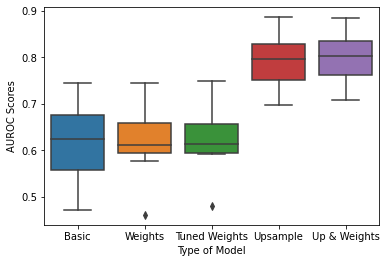

In [75]:
# Run through various log reg models for the avg topic dist models
tune_log_reg(train_df_twitter, train_df_upsampled_twitter, test_df_twitter,
             train_labels, train_labels_upsampled, 
             'Avg Topic Distribution w/All Features', 'avg_topic_dist_models_all_features')





Basic Logistic Regression Model
Log Reg AUROC Scores using tenfold Cross Validation on Training Set 

Mean:  0.6419 Standard Error:  0.033

Weighted Logistic Regression Model with weights of {0: 0.6577, 1: 2.0854}
Log Reg AUROC Scores using tenfold Cross Validation on Training Set 

Mean:  0.6356 Standard Error:  0.033
The weight ratio with the highest AUC score is 0:1.0, 1:2.88, with an AUC score of 0.6357906

Weighted Logistic Regression Model with Tuned Weights of {0: 1.0, 1: 2.88}
Log Reg AUROC Scores using tenfold Cross Validation on Training Set 

Mean:  0.6358 Standard Error:  0.031
The weight ratio with the highest AUC score is 0:1.0, 1:1.21, with an AUC score of 0.7886095

Logistic Regression Model with Upsampled Training Data
Log Reg AUROC Scores using tenfold Cross Validation on Training Set 

Mean:  0.7861 Standard Error:  0.016

Weighted Logistic Regression Model with Upsampled Training Data and weights of {0: 1.0, 1: 1.21}
Log Reg AUROC Scores using tenfold Cross Valid

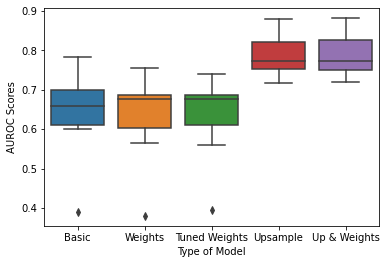

In [76]:
# Run through various log reg models for the max topic dist models
tune_log_reg(train_df_twitter_max, train_df_upsampled_twitter_max, test_df_twitter_max,
             train_labels, train_labels_upsampled, 
             'Max Topic Distribution w/All Features', 'max_topic_dist_models_all_features')





Basic Logistic Regression Model
Log Reg AUROC Scores using tenfold Cross Validation on Training Set 

Mean:  0.6011 Standard Error:  0.029

Weighted Logistic Regression Model with weights of {0: 0.6577, 1: 2.0854}
Log Reg AUROC Scores using tenfold Cross Validation on Training Set 

Mean:  0.6011 Standard Error:  0.029
The weight ratio with the highest AUC score is 0:1.0, 1:2.6, with an AUC score of 0.6025107

Weighted Logistic Regression Model with Tuned Weights of {0: 1.0, 1: 2.6}
Log Reg AUROC Scores using tenfold Cross Validation on Training Set 

Mean:  0.6025 Standard Error:  0.03
The weight ratio with the highest AUC score is 0:1.0, 1:0.5, with an AUC score of 0.9692308

Logistic Regression Model with Upsampled Training Data
Log Reg AUROC Scores using tenfold Cross Validation on Training Set 

Mean:  0.9691 Standard Error:  0.008

Weighted Logistic Regression Model with Upsampled Training Data and weights of {0: 1.0, 1: 0.5}
Log Reg AUROC Scores using tenfold Cross Validation

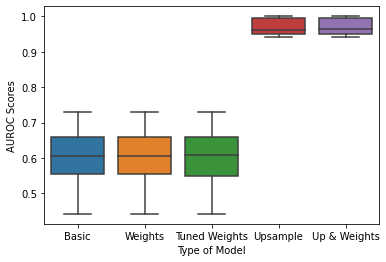

In [77]:
# Run through various log reg models for the temporal topic dist models
tune_log_reg(train_df_twitter_temp, train_df_upsampled_twitter_temp, test_df_twitter_temp,
             train_labels, train_labels_upsampled,
             'Temporal Topic Distribution w/All Features', 'temp_topic_dist_models_all_features')


Random Forest AUROC Scores using tenfold Cross Validation on Training Set 


Basic Random Forest Model
Tenfold Cross Validation on Training Set -- AUCROC Score Mean:  0.6699 
 SE:  0.027

Upsampled Random Forest Model
Tenfold Cross Validation on Training Set -- AUCROC Score Mean:  0.9791 
 SE:  0.008


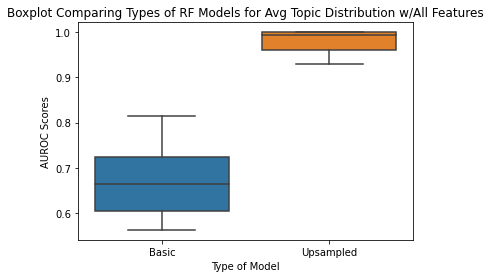

In [78]:
# Run through various rand for models for the avg topic dist models (uses default n estimators and n estimators up)
tune_rf_model(train_df_twitter, train_df_upsampled_twitter, test_df_twitter,
             train_labels, train_labels_upsampled,
             'Avg Topic Distribution w/All Features', 'avg_topic_dist_models_all_features')



Random Forest AUROC Scores using tenfold Cross Validation on Training Set 


Basic Random Forest Model
Tenfold Cross Validation on Training Set -- AUCROC Score Mean:  0.6275 
 SE:  0.028

Upsampled Random Forest Model
Tenfold Cross Validation on Training Set -- AUCROC Score Mean:  0.9778 
 SE:  0.009


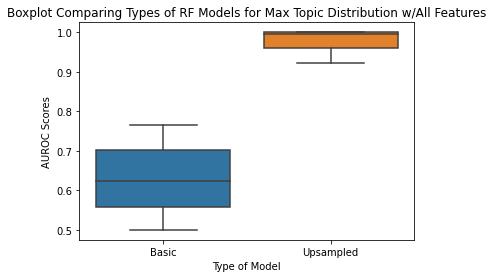

In [79]:
# Run through various rand for models for the max topic dist models
tune_rf_model(train_df_twitter_max, train_df_upsampled_twitter_max, test_df_twitter_max,
             train_labels, train_labels_upsampled,
             'Max Topic Distribution w/All Features', 'max_topic_dist_models_all_features', n_estimators = 569, n_estimators_up = 1741)



Random Forest AUROC Scores using tenfold Cross Validation on Training Set 


Basic Random Forest Model
Tenfold Cross Validation on Training Set -- AUCROC Score Mean:  0.6345 
 SE:  0.022

Upsampled Random Forest Model
Tenfold Cross Validation on Training Set -- AUCROC Score Mean:  0.9834 
 SE:  0.007


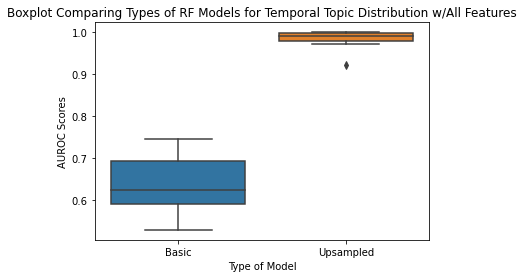

In [80]:
# Run through various rand for models for the temporal topic dist models
tune_rf_model(train_df_twitter_temp, train_df_upsampled_twitter_temp, test_df_twitter_temp,
             train_labels, train_labels_upsampled, 
             'Temporal Topic Distribution w/All Features', 'temp_topic_dist_models_all_features',
             n_estimators= 1663, n_estimators_up = 773)


In [70]:
# Compare baseline/non-twitter models to best log reg models
# Normalize features
train_features_base, test_features_base = normalize_features(train_df_base, test_df_base)
train_features_up_base, test_features_up_base = normalize_features(train_df_upsampled_base, test_df_base)
train_features_up_nontwitter, test_features_up_nontwitter = normalize_features(train_df_upsampled_nontwitter, test_df_nontwitter)
train_features_twitter_temp, test_features_twitter_temp = normalize_features(train_df_twitter_temp, test_df_twitter_temp)

train_features_up_twitter_temp, test_features_up_twitter_temp = normalize_features(train_df_upsampled_twitter_temp, test_df_twitter_temp)
train_features_up_twitter_only_temp, test_features_up_twitter_only_temp = normalize_features(train_df_upsampled_twitter_only_temp, test_df_twitter_only_temp)
train_features_twitter_only_temp, test_features_twitter_only_temp = normalize_features(train_df_twitter_only_temp, test_df_twitter_only_temp)




In [72]:
def find_test_score(train_features, test_features, train_labels, test_labels, title=None, save_as=None, report_scores = True):
    # Fit log reg model
    log_reg_model =  LogisticRegression().fit(train_features, train_labels)
    
    # Fit rand for model
    rand_for_model = RandomForestClassifier(n_estimators=232,random_state=0).fit(train_features,train_labels)
    
    # Find test score
    log_score = roc_auc_score(test_labels, log_reg_model.predict_proba(test_features)[:,1])   
    rand_score = roc_auc_score(test_labels, rand_for_model.predict_proba(test_features)[:,1]) 
    
    # Find precision/recall/f1 scores
    pred_log_score = log_reg_model.predict_proba(test_features)[:,1]
    pred_rand_for = rand_for_model.predict_proba(test_features)[:,1]


    
    if report_scores == True:
        print("\n",f'{title} Log Reg AUROC Score on Test Set: ', round(log_score,4))
        print("\n",f'{title} Random Forest AUROC Score on Test Set: ', round(rand_score,4))
    
        plot_confusion_matrix(log_reg_model, test_features, test_labels)
#         plt.title(f'{title} Log Reg Test Set Confusion Matrix')
        plt.savefig(f'{cwd}{sep}figures{sep}confusion_matrix{sep}lr_{save_as}_test_set_cm.jpg')
        plt.show()
    
        plot_confusion_matrix(rand_for_model, test_features, test_labels)
#         plt.title(f'{title} Rand Forest Test Set Confusion Matrix')
        plt.savefig(f'{cwd}{sep}figures{sep}confusion_matrix{sep}rf_{save_as}_test_set_cm.jpg')
        plt.show()
    
    return log_reg_model, rand_for_model, log_score, rand_score
    


 Base Upsampled Log Reg AUROC Score on Test Set:  0.5306

 Base Upsampled Random Forest AUROC Score on Test Set:  0.4785


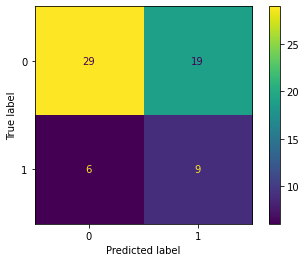

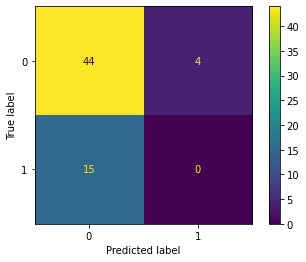


 Nontwitter Upsampled Log Reg AUROC Score on Test Set:  0.6069

 Nontwitter Upsampled Random Forest AUROC Score on Test Set:  0.641


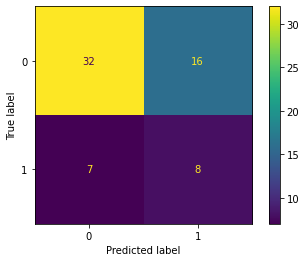

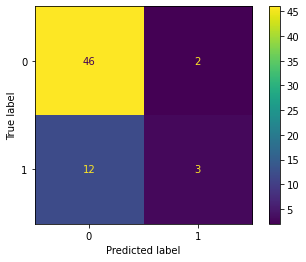


 Twitter Upsampled Log Reg AUROC Score on Test Set:  0.6819

 Twitter Upsampled Random Forest AUROC Score on Test Set:  0.6597


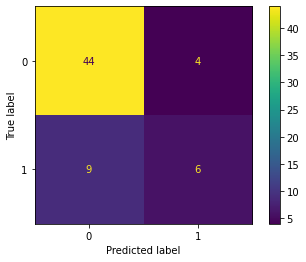

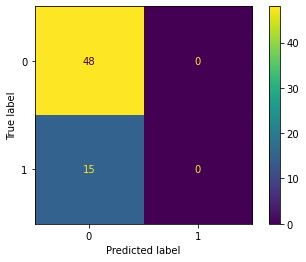

In [73]:
# Baseline Upsampled
base_up_log_reg, base_up_rand_for, base_up_log_score, base_up_rand_score = find_test_score(train_features_up_base, test_features_up_base, 
                                                        train_labels_upsampled, test_labels,
                                                 'Base Upsampled', 'base_up')

# Nontwitter Upsampled
nontwitter_log_reg, nontwitter_rand_for, nontwitter_up_log_score, nontwitter_up_rand_score = find_test_score(train_features_up_nontwitter, test_features_up_nontwitter, 
                                                        train_labels_upsampled, test_labels,
                                                 'Nontwitter Upsampled', 'nontwitter_up')

# Twitter Temporal Upsampled
twitter_up_log_reg, twitter_up_rand_for, twitter_up_log_score, twitter_up_rand_score = find_test_score(train_features_up_twitter_temp, test_features_up_twitter_temp, 
                                                        train_labels_upsampled, test_labels,
                                                 'Twitter Upsampled', 'twitter_up')
                                                      

In [205]:
# Turn AUROC scores into table for LaTeX
base_up_scores = [round(base_up_log_score,4), round(base_up_rand_score,4)]
nontwitter_up_scores = [round(nontwitter_up_log_score,4), round(nontwitter_up_rand_score,4)]
twitter_up_scores = [round(twitter_up_log_score,4), round(twitter_up_rand_score,4)]

auroc_table = pd.DataFrame()
auroc_table['Labels'] = ['Logistic Regression', 'Random Forest']
auroc_table['Baseline Model'] = base_up_scores
auroc_table['NonTwitter Model'] = nontwitter_up_scores
auroc_table['Twitter Model'] = twitter_up_scores

auroc_table = auroc_table.set_index('Labels')
headers = auroc_table.columns.tolist()
# Turn into LaTeX table and output to tex
table_file = open(f"{cwd}{sep}tex{sep}tables{sep}auroc_scores.tex","w")
table = tabulate(auroc_table, headers, tablefmt="latex")
table_lines = [line for line in table]
table_file.writelines(table_lines)
table_file.close()



 Base Log Reg AUROC Score on Test Set:  0.55

 Base Random Forest AUROC Score on Test Set:  0.4868


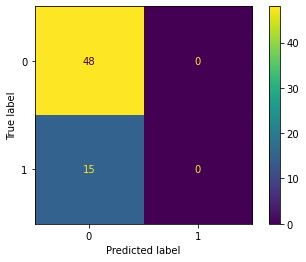

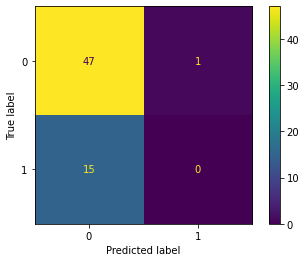


 All Twitter Features Log Reg AUROC Score on Test Set:  0.6736

 All Twitter Features Random Forest AUROC Score on Test Set:  0.7257


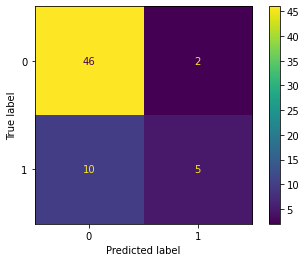

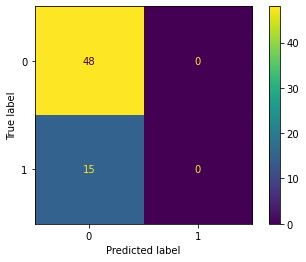


 Twitter Only Log Reg AUROC Score on Test Set:  0.6722

 Twitter Only Random Forest AUROC Score on Test Set:  0.7403


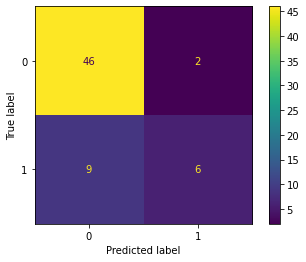

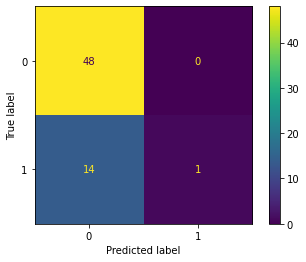


 Twitter Only Upsampled Log Reg AUROC Score on Test Set:  0.6806

 Twitter Only Upsampled Random Forest AUROC Score on Test Set:  0.6299


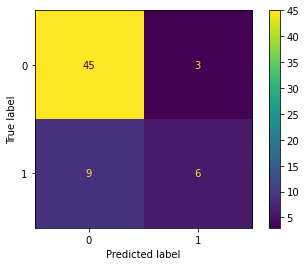

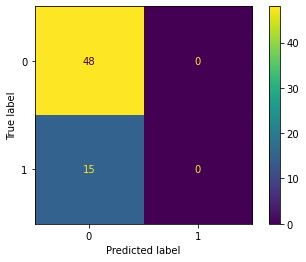

In [209]:
# Appendix Tables
# Baseline Non-Upsampled
base_log_reg, base_rand_for, base_log_score, base_rand_score = find_test_score(train_features_base, test_features_base, train_labels, test_labels,
                                                 'Base', 'base')

# Twitter Temporal Non-Upsampled
twitter_log_reg, twitter_rand_for, twitter_log_score, twitter_rand_score = find_test_score(train_features_twitter_temp, test_features_twitter_temp, 
                                                        train_labels, test_labels,
                                                 'All Twitter Features', 'twitter')
    


# Twitter only Temporal
twitter_only_log_reg, twitter_only_rand_for, twitter_only_log_score, twitter_only_rand_score = find_test_score(train_features_twitter_only_temp, test_features_twitter_only_temp, 
                                                        train_labels, test_labels,
                                                 'Twitter Only', 'twitter_only')



# Twitter only Temporal Upsampled
twitter_only_up_log_reg, twitter_only_up_rand_for, twitter_only_up_log_score, twitter_only_up_rand_score = find_test_score(train_features_up_twitter_only_temp, test_features_up_twitter_only_temp,
                                                                                                                            train_labels_upsampled, test_labels,
                                                 'Twitter Only Upsampled', 'twitter_only_up')


 

In [207]:
# Appendix Table 
base_scores = [round(base_log_score,4), round(base_rand_score,4)]
twitter_scores = [round(twitter_log_score,4), round(twitter_rand_score,4)]
twitter_only_scores = [round(twitter_only_log_score,4), round(twitter_only_rand_score,4)]
twitter_only_up_scores = [round(twitter_only_up_log_score,4), round(twitter_only_up_rand_score,4)]

auroc_table_appendix = pd.DataFrame()
auroc_table_appendix['Labels'] = ['Logistic Regression', 'Random Forest']
auroc_table_appendix['Baseline Model'] = base_scores
auroc_table_appendix['Twitter Model'] = twitter_scores
auroc_table_appendix['Twitter Only Model'] = twitter_only_scores
auroc_table_appendix['Twitter Only Upsampled Model'] = twitter_only_up_scores

auroc_table_appendix = auroc_table_appendix.set_index('Labels')
headers = auroc_table_appendix.columns.tolist()
# Turn into LaTeX table and output to tex
table_file = open(f"{cwd}{sep}tex{sep}tables{sep}auroc_scores_appendix.tex","w")
table = tabulate(auroc_table_appendix, headers, tablefmt="latex")
table_lines = [line for line in table]
table_file.writelines(table_lines)
table_file.close()



In [201]:
# Compare the baseline and non-twitter model to the best log reg models (using temporal)
# Best Model: Temporal Twitter Model with Upsampled/Weighted 
# Weights = 1, 3.32

# Create function that given a particular train/test split, finds the AUROC for that split for the various models tested above
def eval_model(train_df, test_df, ml_model_results, i):
    
    # Prepare features:
    # Upsample train df
    train_df_upsampled = upsample_train_df(train_df).reset_index(drop=True)
    
    #Form np arrays of labels and features.
    train_labels = np.array(train_df.pop('gentrification'))
    train_labels_upsampled = np.array(train_df_upsampled.pop('gentrification'))

    test_labels = np.array(test_df.pop('gentrification'))
    
    # Prepare base/base+nontwitter/all features/twitter only dataframes
    # Create baseline model
    list_of_base_features = ['med_rent_0610','%_black_0610', '%_white_0610', '%_bachelors_0610', '%_unemployed_0610', '%_hhrent_0610']

    train_df_base, train_df_upsampled_base, test_df_base = return_df(list_of_base_features, train_df, train_df_upsampled,
                                                                             test_df)
    # Create model with baseline features plus non-Twitter features
    nontwitter_features = ['total_comm_trend', 'total_res_trend', 'total_res_vacant_ST_trend',
           'total_comm_vacant_ST_trend', 'total_res_vacant_LT_trend',
           'total_comm_vacant_LT_trend', 'crime_0610_trend', 'crime_1113_trend',
           'fel_0610_trend', 'fel_1113_trend', 'crime_pc_0610', 'crime_pc_1113',
           'fel_pc_0610', 'fel_pc_1113', 'noise_1113_trend', 'fhv_1113_trend',
           'bike_1113_trend']
    list_of_nontwitter_features = list_of_base_features + nontwitter_features

    train_df_nontwitter, train_df_upsampled_nontwitter, test_df_nontwitter = return_df(list_of_nontwitter_features, train_df, 
                                                                                                        train_df_upsampled, test_df)

    # Create model w/baseline features plus Twitter features & temporal features
    ym_list = [year+"-"+month for year in ['2011', '2012', '2013'] for month in ['01', '02', '03', '04', '05', '06', '07', '08',
                                                                                '09', '10', '11', '12']]
    topic_temporal_list = ['topic'+str(i)+"_"+ym for i in range(45) for ym in ym_list]
    topic_temp_features = ['%_english_tweets_trend', 'tweets_count_trend',
           'first_tweet_count', 'last_tweet_count', 'avg_tweet_count'] + topic_temporal_list

    list_of_temp_twitter_features = list_of_nontwitter_features + topic_temp_features

    train_df_twitter_temp, train_df_upsampled_twitter_temp, test_df_twitter_temp = return_df(list_of_temp_twitter_features, train_df, 
                                                                                    train_df_upsampled, test_df)

    train_df_twitter_only_temp, train_df_upsampled_twitter_only_temp, test_df_twitter_only_temp = return_df(topic_temp_features, train_df, 
                                                                                                    train_df_upsampled, test_df)

    # Normalize features
    train_features_base, test_features_base = normalize_features(train_df_base, test_df_base)
    train_features_up_base, test_features_up_base = normalize_features(train_df_upsampled_base, test_df_base)
    train_features_up_nontwitter, test_features_up_nontwitter = normalize_features(train_df_upsampled_nontwitter, test_df_nontwitter)
    train_features_twitter_temp, test_features_twitter_temp = normalize_features(train_df_twitter_temp, test_df_twitter_temp)

    train_features_up_twitter_temp, test_features_up_twitter_temp = normalize_features(train_df_upsampled_twitter_temp, test_df_twitter_temp)
    train_features_up_twitter_only_temp, test_features_up_twitter_only_temp = normalize_features(train_df_upsampled_twitter_only_temp, test_df_twitter_only_temp)


        
    base_log_reg, base_rand_for, base_log_score, base_rand_score = find_test_score(train_features_base, test_features_base, 
                                                                                   train_labels, test_labels,report_scores=False
                            )
    
    # Put models in model_dict
    ml_model_results['base_log_reg'][i]=base_log_reg
    ml_model_results['base_rand_for'][i]=base_rand_for


    base_up_log_reg, base_up_rand_for, base_up_log_score, base_up_rand_score = find_test_score(train_features_up_base, test_features_up_base, 
                                                            train_labels_upsampled, test_labels,
                                                     report_scores=False)
    ml_model_results['base_up_log_reg'][i]=base_up_log_reg
    ml_model_results['base_up_rand_for'][i]=base_up_rand_for

    # Nontwitter Upsampled
    nontwitter_up_log_reg, nontwitter_up_rand_for, nontwitter_up_log_score, nontwitter_up_rand_score = find_test_score(train_features_up_nontwitter, test_features_up_nontwitter, 
                                                            train_labels_upsampled, test_labels,
                                                     report_scores=False)
    ml_model_results['nontwitter_up_log_reg'][i] = nontwitter_up_log_reg
    ml_model_results['nontwitter_up_rand_for'][i] = nontwitter_up_rand_for

    # Twitter Temporal
    twitter_log_reg, twitter_rand_for, twitter_log_score, twitter_rand_score = find_test_score(train_features_twitter_temp, test_features_twitter_temp, 
                                                            train_labels, test_labels,
                                                     report_scores=False)
    ml_model_results['twitter_log_reg'][i] = twitter_log_reg
    ml_model_results['twitter_rand_for'][i] = twitter_rand_for
    
    # Twitter Temporal Upsampled
    twitter_up_log_reg, twitter_up_rand_for, twitter_up_log_score, twitter_up_rand_score = find_test_score(train_features_up_twitter_temp, test_features_up_twitter_temp, 
                                                            train_labels_upsampled, test_labels,
                                                     report_scores=False)
    ml_model_results['twitter_up_log_reg'][i] = twitter_up_log_reg
    ml_model_results['twitter_up_rand_for'][i] = twitter_up_rand_for

    # Twitter only Temporal Upsampled
    twitter_only_up_log_reg, twitter_only_up_rand_for, twitter_only_up_log_score, twitter_only_up_rand_score = find_test_score(train_features_up_twitter_only_temp, test_features_up_twitter_only_temp, 
                                                            train_labels_upsampled, test_labels,
                                                     report_scores=False)
    ml_model_results['twitter_only_up_log_reg'][i] = twitter_only_up_log_reg
    ml_model_results['twitter_only_up_rand_for'][i] = twitter_only_up_rand_for
    
    
    return base_log_score, base_rand_score, base_up_log_score, base_up_rand_score, nontwitter_up_log_score, nontwitter_up_rand_score, twitter_log_score,twitter_rand_score, \
    twitter_up_log_score, twitter_up_rand_score, twitter_only_up_log_score, twitter_only_up_rand_score

    

In [41]:
# # Run through different iterations of the train/test split and find 
# base_log_scores = []
# base_rand_scores = []
# base_up_log_scores = []
# base_up_rand_scores = []
# nontwitter_up_log_scores = []
# nontwitter_up_rand_scores = []
# twitter_log_scores = []
# twitter_rand_scores= []
# twitter_up_log_scores = []
# twitter_up_rand_scores = []
# twitter_only_up_log_scores = []
# twitter_only_up_rand_scores = []

# # Combine train/test
# train_df_temp = labels_gdf.merge(non_twitter_features.merge(tweets_features_train.merge(topic_dist_temp, on='LocationCT'), on='LocationCT'), on='LocationCT')
# test_df_temp = labels_gdf.merge(non_twitter_features.merge(tweets_features_test.merge(topic_dist_temp, on='LocationCT'), on='LocationCT'), on='LocationCT')
# train_df_temp = train_df_temp[train_df_temp['eligible_gentrify'] == 1].reset_index(drop=True)
# test_df_temp = test_df_temp[test_df_temp['eligible_gentrify'] == 1].reset_index(drop=True)

# df_full = train_df_temp.append(test_df_temp).reset_index(drop=True)
# locations = df_full['LocationCT']

# ml_model_results = {'base_log_reg':{}, 'base_rand_for': {}, 'base_up_log_reg': {}, 'base_up_rand_for': {}, 'nontwitter_up_log_reg':{}, 'nontwitter_up_rand_for': {},'twitter_log_reg':{}, 'twitter_rand_for': {},
#               'twitter_up_log_reg':{}, 'twitter_up_rand_for':{},'twitter_only_up_log_reg':{}, 'twitter_only_up_rand_for':{}}

In [35]:
from sklearn.model_selection import train_test_split

In [40]:
# i = 1
# n_iter = 500
# while i <= n_iter:
#     train_locations, test_locations = train_test_split(locations, test_size = 0.15)
#     train_df_new = df_full.merge(train_locations,on='LocationCT')
#     test_df_new = df_full.merge(test_locations, on='LocationCT')
#     base_log_score, base_rand_score, base_up_log_score, base_up_rand_score, nontwitter_up_log_score, nontwitter_up_rand_score, twitter_log_score,twitter_rand_score, \
#         twitter_up_log_score, twitter_up_rand_score, twitter_only_up_log_score, twitter_only_up_rand_score = eval_model(train_df_new,test_df_new,ml_model_results,i)

#     base_log_scores.append(base_log_score)
#     base_rand_scores.append(base_rand_score)
#     base_up_log_scores.append(base_up_log_score)
#     base_up_rand_scores.append(base_up_log_score)
#     nontwitter_up_log_scores.append(nontwitter_up_log_score)
#     nontwitter_up_rand_scores.append(nontwitter_up_rand_score)
#     twitter_log_scores.append(twitter_log_score)
#     twitter_rand_scores.append(twitter_rand_score)
#     twitter_up_log_scores.append(twitter_up_log_score)
#     twitter_up_rand_scores.append(twitter_up_rand_score)
#     twitter_only_up_log_scores.append(twitter_only_up_log_score)
#     twitter_only_up_rand_scores.append(twitter_only_up_rand_score)
#     if i%10 == 0:
#         print(f'another 10 done! {i} iterations done!')
#     i += 1


In [37]:
# # Pickle lists created above
# pickle.dump(base_log_scores, open(f'{cwd}{sep}pickle{sep}base_log_scores.pickle', 'wb'))
# pickle.dump(base_rand_scores, open(f'{cwd}{sep}pickle{sep}base_rand_scores.pickle', 'wb'))
# pickle.dump(base_up_log_scores, open(f'{cwd}{sep}pickle{sep}base_up_log_scores.pickle', 'wb'))
# pickle.dump(base_up_rand_scores, open(f'{cwd}{sep}pickle{sep}base_up_rand_scores.pickle', 'wb'))
# pickle.dump(nontwitter_up_log_scores, open(f'{cwd}{sep}pickle{sep}nontwitter_up_log_scores.pickle', 'wb'))
# pickle.dump(nontwitter_up_rand_scores, open(f'{cwd}{sep}pickle{sep}nontwitter_up_rand_scores.pickle', 'wb'))
# pickle.dump(twitter_log_scores, open(f'{cwd}{sep}pickle{sep}twitter_log_scores.pickle', 'wb'))
# pickle.dump(twitter_rand_scores, open(f'{cwd}{sep}pickle{sep}twitter_rand_scores.pickle', 'wb'))
# pickle.dump(twitter_up_log_scores, open(f'{cwd}{sep}pickle{sep}twitter_up_log_scores.pickle', 'wb'))
# pickle.dump(twitter_up_rand_scores, open(f'{cwd}{sep}pickle{sep}twitter_up_rand_scores.pickle', 'wb'))
# pickle.dump(twitter_only_up_log_scores, open(f'{cwd}{sep}pickle{sep}twitter_only_up_log_scores.pickle', 'wb'))
# pickle.dump(twitter_only_up_rand_scores, open(f'{cwd}{sep}pickle{sep}twitter_only_up_rand_scores.pickle', 'wb'))

# # Pickle model
# pickle.dump(ml_model_results, open(f'{cwd}{sep}pickle{sep}tt_split_ml_model_results.pickle', 'wb'))


In [47]:
# from sklearn.metrics import recall_score, precision_score, f1_score
# from sklearn.metrics import roc_auc_score, accuracy_score
# base_log_reg = ml_model_results['base_log_reg'][1]
# base_rand_for =  ml_model_results['base_rand_for'][1]
# pred_score = base_log_reg.predict(test_features_base)
# #pred_binary_score = np.array([0 if i < 0.5 else 1 for i in pred_score])
# recall = recall_score(test_labels, pred_score)
# recall

In [38]:
from statistics import mean

In [159]:
# Find mean & SEs of different models
lr_scores = []
lr_labels = []

lr_scores.extend(base_log_scores)
lr_labels.extend(['Base' for score in base_log_scores])
mean_base, std_base = mean(base_log_scores), sem(base_log_scores)
log_report_base = str(round(mean_base,4))+f" ({round(std_base,3)})"

lr_scores.extend(base_up_log_scores)
lr_labels.extend(['Base Up' for score in base_up_log_scores])
mean_base_up, std_base_up = mean(base_up_log_scores), sem(base_up_log_scores)
log_report_base_up = str(round(mean_base_up,4))+f" ({round(std_base_up,3)})"

lr_scores.extend(nontwitter_up_log_scores)
lr_labels.extend(['Nontwitter Up' for score in nontwitter_up_log_scores])
mean_nontwitter, std_nontwitter = mean(nontwitter_up_log_scores), sem(nontwitter_up_log_scores)
log_report_nontwitter = str(round(mean_nontwitter,4))+f" ({round(std_nontwitter,3)})"

lr_scores.extend(twitter_log_scores)
lr_labels.extend(['Twitter' for score in twitter_log_scores])
mean_twitter, std_twitter = mean(twitter_log_scores), sem(twitter_log_scores)
log_report_twitter = str(round(mean_twitter,4))+f" ({round(std_twitter,3)})"

lr_scores.extend(twitter_up_log_scores)
lr_labels.extend(['Twitter Up' for score in twitter_up_log_scores])
mean_twitter_up, std_twitter_up = mean(twitter_up_log_scores), sem(twitter_up_log_scores)
log_report_twitter_up = str(round(mean_twitter_up,4))+f" ({round(std_twitter_up,3)})"

lr_scores.extend(twitter_only_up_log_scores)
lr_labels.extend(['Twitter Only' for score in twitter_only_up_log_scores])
mean_twitter_only, std_twitter_only = mean(twitter_only_up_log_scores), sem(twitter_only_up_log_scores)
log_report_twitter_only = str(round(mean_twitter_only,4))+f" ({round(std_twitter_only,3)})"


rf_scores = []
rf_labels = []
rf_scores.extend(base_rand_scores)
rf_labels.extend(['Base' for score in base_rand_scores])
mean_base, std_base = mean(base_rand_scores), sem(base_rand_scores)
rf_report_base = str(round(mean_base,4))+f" ({round(std_base,3)})"

rf_scores.extend(base_up_rand_scores)
rf_labels.extend(['Base Up' for score in base_up_rand_scores])
mean_base, std_base = mean(base_up_rand_scores), sem(base_up_rand_scores)
rf_report_base_up = str(round(mean_base_up,4))+f" ({round(std_base_up,3)})"

rf_scores.extend(nontwitter_up_rand_scores)
rf_labels.extend(['Nontwitter Up' for score in nontwitter_up_log_scores])
mean_nontwitter, std_nontwitter = mean(nontwitter_up_rand_scores), sem(nontwitter_up_rand_scores)
rf_report_nontwitter = str(round(mean_nontwitter,4))+f" ({round(std_nontwitter,3)})"

rf_scores.extend(twitter_rand_scores)
rf_labels.extend(['Twitter' for score in twitter_rand_scores])
mean_twitter, std_twitter = mean(twitter_rand_scores), sem(twitter_rand_scores)
rf_report_twitter = str(round(mean_twitter,4))+f" ({round(std_twitter,3)})"

rf_scores.extend(twitter_up_rand_scores)
rf_labels.extend(['Twitter Up' for score in twitter_up_rand_scores])
mean_twitter_up, std_twitter_up = mean(twitter_up_rand_scores), sem(twitter_up_rand_scores)
rf_report_twitter_up = str(round(mean_twitter_up,4))+f" ({round(std_twitter_up,3)})"

rf_scores.extend(twitter_only_up_rand_scores)
rf_labels.extend(['Twitter Only' for score in twitter_up_rand_scores])
mean_twitter_only, std_twitter_only = mean(twitter_up_rand_scores), sem(twitter_up_rand_scores)
rf_report_twitter_only = str(round(mean_twitter_only,4))+f" ({round(std_twitter_only,3)})"


# LR
# Make boxplot. First turn into df
lr_scores_df = pd.DataFrame(lr_scores,lr_labels).reset_index().rename(columns={'index':'Type of Model', 0:'AUROC Scores'})
ax = sns.boxplot(x ='Type of Model', y='AUROC Scores', data=lr_scores_df)
plt.title(f'LR Models with Different Train/Test Splits')
plt.savefig(f'{cwd}{sep}figures{sep}boxplots{sep}lr_models_train_test.jpg')
plt.show()
    
# Make table of means/SE of AUROC scores. Turn into df and then output to LaTeX
headers = ["Type of LR Model", "Mean Score (SE)"]
table_labels = ['Basic', 'Basic Upsampled', 'Nontwitter', "Twitter", "Twitter Upsampled", "Twitter Only Upsampled"]
report_list = [log_report_base, log_report_base_up,log_report_nontwitter,log_report_twitter,log_report_twitter_up,log_report_twitter_only]
table_df = pd.DataFrame(report_list,table_labels).reset_index().rename(columns={'index':'Type of LR Model', 0:'AUROC Mean (SE)'})

table_file = open(f"{cwd}{sep}tex{sep}tables{sep}lr_test_train_split.tex","w")
table = tabulate(table_df, headers, tablefmt="latex")
table_lines = [line for line in table]
table_file.writelines(table_lines)
table_file.close()

    
#RF
# Make boxplot. First turn into df
scores_df = pd.DataFrame(rf_scores,rf_labels).reset_index().rename(columns={'index':'Type of Model', 0:'AUROC Scores'})
ax = sns.boxplot(x ='Type of Model', y='AUROC Scores', data=scores_df)
plt.title(f'RF Models with Different Train/Test Splits')
plt.savefig(f'{cwd}{sep}figures{sep}boxplots{sep}rf_models_train_test.jpg')
plt.show()
    
# Make table of means/SE of AUROC scores. Turn into df and then output to LaTeX
headers = ["Type of RF Model", "Mean Score (SE)"]
table_labels = ['Basic', 'Basic Upsampled','Nontwitter', "Twitter", "Twitter Upsampled", "Twitter Only Upsampled"]
report_list = [rf_report_base,rf_report_base_up, rf_report_nontwitter,rf_report_twitter,rf_report_twitter_up,rf_report_twitter_only]
table_df = pd.DataFrame(report_list,table_labels).reset_index().rename(columns={'index':'Type of RF Model', 0:'AUROC Mean (SE)'})

table_file = open(f"{cwd}{sep}tex{sep}tables{sep}rf_test_train_split.tex","w")
table = tabulate(table_df, headers, tablefmt="latex")
table_lines = [line for line in table]
table_file.writelines(table_lines)
table_file.close()
    

NameError: name 'base_log_scores' is not defined

In [93]:
# Generate list of features 
nontwitter_names = ['Trend in Commercial Addresses', 'Trend in Residential Addresses', 'Trend in ST Vacant Residential Addresses',
       'Trend in ST Vacant Commercial Addresses', 'Trend in Vacant LT Residential Addresses',
       'Trend in Vacant LT Commercial Addresses', 'Crime Trendline 06-10', 'Crime Trendline 11-13',
       'Felony Trendline 06-10', 'Felony Trendline 11-13', 'Crime PC 06-10', 'Crime PC 11-13',
       'Felonies PC 06-10', 'Felonies PC 11-13', 'Noise Reports Trend 11-13', 'For-Hire Vehicle Complaints Trend 11-13',
       'Bike Rack Complaints Trend 11-13']
temporal_topic_names = ['Topic '+str(i)+" Distribution: "+ym for i in range(45) for ym in ym_list]

twitter_only_features_names = ['Trend in Percentage of English-Lang Tweets', 'Trend in Total Tweet Count',
       'Tweet Count-Beginning', 'Tweet Count-End', 'Average Tweet Count'] + temporal_topic_names

list_of_base_features_names = ['Median Rent', 'Percent Black', 'Percent White', 'Percent Bachelors', 'Percent Unemployed', 'Percent of HHs Renting']
list_of_nontwitter_features_names = list_of_base_features_names + nontwitter_names
list_of_twitter_features_names = list_of_nontwitter_features_names + twitter_only_features_names



In [244]:
# Feature importance. From Original train/test split.
# LR features

def find_top_features_log(log_reg_model, list_of_features, plot_title,save_as,x=10):
    feature_table_list = []
    feature_mean_list = []
    
    # Use absolute values to order elements
    print("Model: ", save_as)
    full_array_mean = log_reg_model.coef_[0]
    full_array_mean_abs = np.absolute(full_array_mean)
    order_reverse = np.argsort(np.argsort(full_array_mean_abs)).tolist()
    array_len = len(full_array_mean)
    order = [array_len-order_reverse[i] for i in range(array_len)]

    # Print out the top x features
    for i in range(1,x+1):
        try:
            feature_index = order.index(i)
            if i == 1:
                suffix = "st"
            elif i == 2:
                suffix = 'nd'
            elif i == 3:
                suffix = 'rd'
            else:
                suffix = 'th'
            print(f'The {i}{suffix} most important element is {list_of_features[feature_index]}: \
                  {round(full_array_mean[feature_index],4)}')
            feature_table_list.append(list_of_features[feature_index])
            feature_mean_list.append(round(full_array_mean[feature_index],4))

        except ValueError:
            continue
    table_dict = {'Top Features': feature_table_list, 'LR Beta Value': feature_mean_list}
    table_df = pd.DataFrame.from_dict(table_dict)
    
    # Create plots with top x elements using the list created above    
    #plt.barh(feature_table_list, feature_mean_list)
    # Create plots with top x elements using the list created above    
    to_plot_df = table_df.copy().set_index('Top Features')
    ax = to_plot_df.plot.barh(legend=False)
    ax.invert_yaxis()
    plt.xlabel("Log Coefficient")
    plt.ylabel('Top Features')
#     plt.title(f'{plot_title} Logistic Regression Most Important Coefficients')
    plt.savefig(f'{cwd}{sep}figures{sep}feature_importance{sep}{save_as}_log_coefficients.jpg', bbox_inches="tight")
    plt.show()
    
    return table_df
    

def find_top_features_rand(rand_for_model, list_of_features, plot_title, save_as, x=10):
    print("Model: ", save_as)
    feature_table_list = []
    feature_mean_list = []
    full_array_mean = rand_for_model.feature_importances_
    order_reverse = np.argsort(np.argsort(full_array_mean)).tolist()
    array_len = len(full_array_mean)
    order = [array_len-order_reverse[i] for i in range(array_len)]

    # Print out the top x features
    for i in range(1,x+1):
        try:
            feature_index = order.index(i)
            if i == 1:
                suffix = "st"
            elif i == 2:
                suffix = 'nd'
            elif i == 3:
                suffix = 'rd'
            else:
                suffix = 'th'
            print(f'The {i}{suffix} most important element is {list_of_features[feature_index]}: \
                  {round(full_array_mean[feature_index],4)}')
            feature_table_list.append(list_of_features[feature_index])
            feature_mean_list.append(round(full_array_mean[feature_index],4))

        except ValueError:
            continue
    table_dict = {'Top Features': feature_table_list, 'RF Gini Importance': feature_mean_list}
    table_df = pd.DataFrame.from_dict(table_dict)
        
    # Create plots with top x elements using the list created above    
    to_plot_df = table_df.copy().set_index('Top Features')
    ax = to_plot_df.plot.barh(legend=False)
    # For some reason, is returning bottom to top, reverse this
    ax.invert_yaxis()
    plt.xlabel("Importance")
    plt.ylabel('Top Features')
#     plt.title(f'{plot_title} Random Forest Gini Importance')
    plt.savefig(f'{cwd}{sep}figures{sep}feature_importance{sep}{save_as}_feature_importance.jpg', bbox_inches="tight")
    plt.show()
    
    
    return table_df

def find_top_features(log_reg_model, rand_for_model, list_of_features, plot_title, save_as_log, save_as_rand,save_as_table, x=10):
    # Find top features for log and rand (and form plot). Then turn into a LaTeX table.
    log_table_df = find_top_features_log(log_reg_model, list_of_features, plot_title, save_as_log,x=x)
    rand_table_df = find_top_features_rand(rand_for_model, list_of_features, plot_title, save_as_rand, x=x)
    merged_top_features_df = log_table_df.merge(rand_table_df, on='Top Features', how='outer')
    merged_top_features_df = merged_top_features_df.fillna('N/A')
    merged_top_features_df = merged_top_features_df.set_index('Top Features')
    
    headers = ['Top Features', 'LR Beta Value', 'RF Gini Importance']
    table_file = open(f"{cwd}{sep}tex{sep}tables{sep}all_feature_importance_{save_as_table}.tex","w")
    table = tabulate(merged_top_features_df, headers, tablefmt="latex")
    table_lines = [line for line in table]
    table_file.writelines(table_lines)
    table_file.close()



Model:  base_up_log_reg
The 1st most important element is Percent Black:                   0.4726
The 2nd most important element is Percent White:                   0.2115
The 3rd most important element is Percent of HHs Renting:                   0.2111
The 4th most important element is Percent Unemployed:                   -0.0931
The 5th most important element is Median Rent:                   -0.0668
The 6th most important element is Percent Bachelors:                   -0.0088


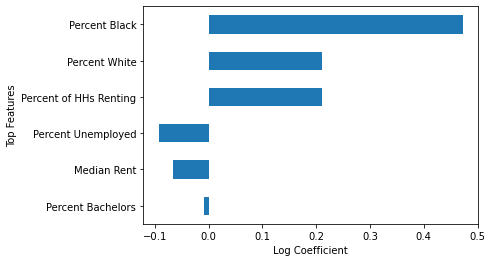

Model:  base_up_rand_for
The 1st most important element is Percent Black:                   0.1954
The 2nd most important element is Percent White:                   0.1794
The 3rd most important element is Percent Unemployed:                   0.1727
The 4th most important element is Percent of HHs Renting:                   0.1562
The 5th most important element is Median Rent:                   0.1501
The 6th most important element is Percent Bachelors:                   0.1463


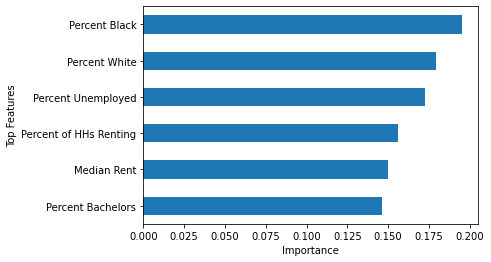

Model:  nontwitter_up_log_reg
The 1st most important element is Felonies PC 06-10:                   2.1207
The 2nd most important element is Crime PC 06-10:                   -1.5589
The 3rd most important element is Noise Reports Trend 11-13:                   0.8709
The 4th most important element is Felonies PC 11-13:                   -0.7184
The 5th most important element is Crime Trendline 06-10:                   0.53
The 6th most important element is Percent Black:                   0.5134
The 7th most important element is Felony Trendline 06-10:                   -0.4712
The 8th most important element is Percent Bachelors:                   -0.3057
The 9th most important element is Crime Trendline 11-13:                   0.2908
The 10th most important element is Percent of HHs Renting:                   0.2342
The 11th most important element is Crime PC 11-13:                   -0.1803
The 12th most important element is Percent White:                   0.157
The 13th most imp

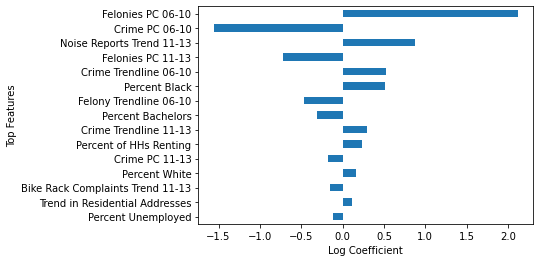

Model:  nontwitter_up_rand_for
The 1st most important element is Percent Black:                   0.0825
The 2nd most important element is Noise Reports Trend 11-13:                   0.0821
The 3rd most important element is Percent Unemployed:                   0.0563
The 4th most important element is Percent White:                   0.0539
The 5th most important element is Median Rent:                   0.0496
The 6th most important element is Crime PC 11-13:                   0.0468
The 7th most important element is Felony Trendline 11-13:                   0.0467
The 8th most important element is Percent Bachelors:                   0.0451
The 9th most important element is Felony Trendline 06-10:                   0.0446
The 10th most important element is Trend in Residential Addresses:                   0.0439
The 11th most important element is Crime Trendline 11-13:                   0.0433
The 12th most important element is Trend in ST Vacant Residential Addresses:              

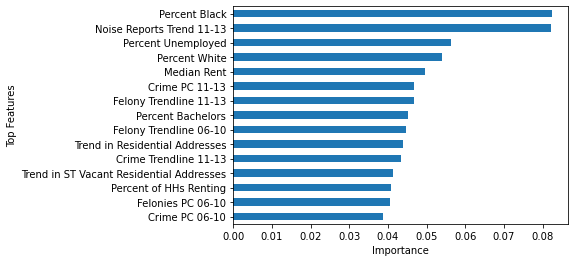

Model:  twitter_up_log_reg
The 1st most important element is Topic 3 Distribution: 2011-12:                   0.3105
The 2nd most important element is Topic 39 Distribution: 2013-07:                   -0.276
The 3rd most important element is Topic 3 Distribution: 2013-05:                   0.2431
The 4th most important element is Noise Reports Trend 11-13:                   0.2364
The 5th most important element is Topic 25 Distribution: 2012-04:                   0.2327
The 6th most important element is Topic 32 Distribution: 2012-07:                   -0.2111
The 7th most important element is Topic 17 Distribution: 2011-09:                   -0.2081
The 8th most important element is Topic 16 Distribution: 2013-01:                   0.207
The 9th most important element is Topic 17 Distribution: 2013-08:                   -0.2052
The 10th most important element is Topic 19 Distribution: 2012-03:                   0.2009
The 11th most important element is Topic 23 Distribution: 2013-10: 

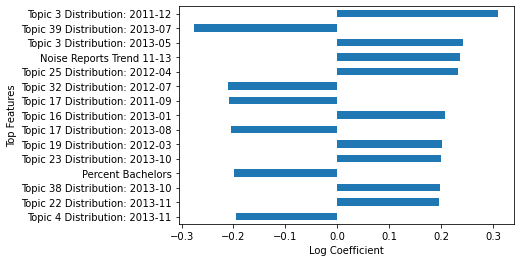

Model:  twitter_up_rand_for
The 1st most important element is Topic 3 Distribution: 2012-07:                   0.0051
The 2nd most important element is Topic 20 Distribution: 2013-07:                   0.0051
The 3rd most important element is Topic 30 Distribution: 2012-05:                   0.0049
The 4th most important element is Topic 22 Distribution: 2013-12:                   0.0047
The 5th most important element is Topic 35 Distribution: 2013-07:                   0.0044
The 6th most important element is Topic 44 Distribution: 2013-11:                   0.004
The 7th most important element is Topic 30 Distribution: 2013-07:                   0.0037
The 8th most important element is Topic 39 Distribution: 2013-11:                   0.0037
The 9th most important element is Noise Reports Trend 11-13:                   0.0034
The 10th most important element is Topic 3 Distribution: 2013-05:                   0.0033
The 11th most important element is Topic 2 Distribution: 2013-10:    

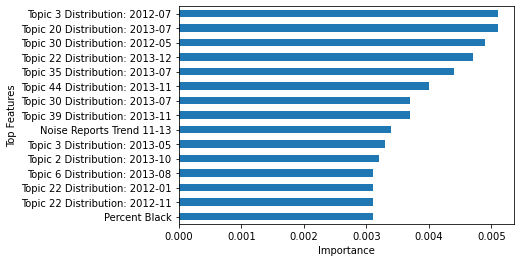

In [245]:
# Find most important features for the 3 relevant models
find_top_features(base_up_log_reg, base_up_rand_for, list_of_base_features_names, 'Baseline Upsampled', 'base_up_log_reg', 
                  'base_up_rand_for','base_up')

find_top_features(nontwitter_log_reg, nontwitter_rand_for, list_of_nontwitter_features_names, 'Nontwitter Upsampled', 'nontwitter_up_log_reg', 
                  'nontwitter_up_rand_for','nontwitter_up', x=15)

find_top_features(twitter_up_log_reg, twitter_up_rand_for, list_of_twitter_features_names, 'Twitter Upsampled', 'twitter_up_log_reg', 
                  'twitter_up_rand_for','twitter_up', x=15)



In [375]:
# Feature importance for test/train split
# LR features

# Generate a matrix made up of arrays corresponding to model coefficients. Then find the mean/sem & return the top 10 features (and print to LaTeX table)
def find_top_features_log(log_reg_model, list_of_features, plot_title,save_as,x=10):
    print("Model: ", log_reg_model)
    feature_table_list = []
    feature_mean_sem_list = []
    feature_abs_value_mean_list = []
    feature_mean_list  = []
    full_array = np.array([ml_model_results[log_reg_model][i].coef_[0] for i in range(1,501)])
    full_array_mean = np.mean(full_array, axis=0)
    full_array_sem = sem(full_array, axis=0)
    full_array_mean_abs = np.absolute(full_array_mean)
    order_reverse = np.argsort(np.argsort(full_array_mean_abs)).tolist()
    array_len = len(full_array_mean)
    order = [array_len-order_reverse[i] for i in range(array_len)]

    # Print out the top x features
    for i in range(1,x+1):
        try:
            feature_index = order.index(i)
            if i == 1:
                suffix = "st"
            elif i == 2:
                suffix = 'nd'
            elif i == 3:
                suffix = 'rd'
            else:
                suffix = 'th'
            # Add stars (3 (p<0.01) if z-score (abs value)> 2.576, 2 (p<0.05) if z-score > 1.96, 1 (p<0.10) if z-score > 1.645)
            if full_array_mean_abs[feature_index]/full_array_sem[feature_index] > 2.576:
                stars = "***"
            elif full_array_mean_abs[feature_index]/full_array_sem[feature_index] > 1.96:
                stars = "**"
            elif full_array_mean_abs[feature_index]/full_array_sem[feature_index] > 1.645:
                stars = "*"
            else:
                stars=""
            print(f'The {i}{suffix} most important element is {list_of_features[feature_index]}: \
                  {round(full_array_mean[feature_index],4)}{stars} ({round(full_array_sem[feature_index],3)})')
            feature_table_list.append(list_of_features[feature_index])
            feature_mean_sem_list.append(str(round(full_array_mean[feature_index],4))+ stars+" (" + str(round(full_array_sem[feature_index],3)) + ")")
            feature_abs_value_mean_list.append(full_array_mean_abs[feature_index])
            feature_mean_list.append(full_array_mean[feature_index])

        except ValueError:
            continue
    table_dict = {'Feature': feature_table_list, 'Mean (SE)': feature_mean_sem_list}
    table_df = pd.DataFrame.from_dict(table_dict)
    
    # Create plots with top x elements using the list created above    
    plt.barh(feature_table_list, feature_mean_list)
    plt.xlabel("Importance")
    plt.ylabel('Feature')
    plt.title(f'{plot_title} Logistic Regression Most Important Coefficients')
    plt.savefig(f'{cwd}{sep}figures{sep}feature_importance{sep}{save_as}_log_coefficients.jpg', bbox_inches="tight")
    plt.show()
    
    # Create LaTeX table with top elements
    headers = ['Feature', 'Mean (SE)']
    table_file = open(f"{cwd}{sep}tex{sep}tables{sep}feature_importance_{save_as}.tex","w")
    table = tabulate(table_df, headers, tablefmt="latex")
    table_lines = [line for line in table]
    table_file.writelines(table_lines)
    table_file.close()
    print('\n')
    return table_df
    


# RF Features
def find_top_features_rand(rand_for_model, list_of_features, plot_title, save_as, x=10):
    print("Model: ", rand_for_model)
    feature_table_list = []
    feature_mean_sem_list = []
    feature_mean_list = []
    # Find feature importance for all 500 models
    full_array = np.array([ml_model_results[rand_for_model][i].feature_importances_ for i in range(1,501)])
    # Find mean
    full_array_mean = np.mean(full_array, axis=0)
    # Find SEM 
    full_array_sem = sem(full_array, axis=0)
    
    order_reverse = np.argsort(np.argsort(full_array_mean)).tolist()
    array_len = len(full_array_mean)
    order = [array_len-order_reverse[i] for i in range(array_len)]

    # Print out the top x features
    for i in range(1,x+1):
        try:
            feature_index = order.index(i)
            if i == 1:
                suffix = "st"
            elif i == 2:
                suffix = 'nd'
            elif i == 3:
                suffix = 'rd'
            else:
                suffix = 'th'
            # Add stars (3 (p<0.01) if z-score (abs value)> 2.576, 2 (p<0.05) if z-score > 1.96, 1 (p<0.10) if z-score > 1.645)
            if full_array_mean[feature_index]/full_array_sem[feature_index] > 2.576:
                stars = "***"
            elif full_array_mean[feature_index]/full_array_sem[feature_index] > 1.96:
                stars = "**"
            elif full_array_mean[feature_index]/full_array_sem[feature_index] > 1.645:
                stars = "*"
            else:
                stars=""
            print(f'The {i}{suffix} most important element is {list_of_features[feature_index]}: \
                  {round(full_array_mean[feature_index],4)}{stars} ({round(full_array_sem[feature_index],3)})')
            feature_table_list.append(list_of_features[feature_index])
            feature_mean_list.append(full_array_mean[feature_index])
            feature_mean_sem_list.append(str(round(full_array_mean[feature_index],4))+ stars+" (" + str(round(full_array_sem[feature_index],3)) + ")")

        except ValueError:
            continue
    table_dict = {'Feature': feature_table_list, 'Mean (SE)': feature_mean_sem_list}
    table_df = pd.DataFrame.from_dict(table_dict)
    
    # Create plots with top x elements using the list created above    
    plt.barh(feature_table_list, feature_mean_list)
    plt.xlabel("Importance")
    plt.ylabel('Feature')
    plt.title(f'{plot_title} Random Forest Gini Importance')
    plt.savefig(f'{cwd}{sep}figures{sep}feature_importance{sep}{save_as}_feature_importance.jpg', bbox_inches="tight")
    plt.show()
    
    # Create LaTeX table with top elements
    headers = ['Feature', 'Mean (SE)']
    table_file = open(f"{cwd}{sep}tex{sep}tables{sep}feature_importance_{save_as}.tex","w")
    table = tabulate(table_df, headers, tablefmt="latex")
    table_lines = [line for line in table]
    table_file.writelines(table_lines)
    table_file.close()
    print('\n')
    return table_df
    
    
    
    

Model:  base_log_reg
The 1st most important element is Percent Black:                   0.5213*** (0.003)
The 2nd most important element is Percent White:                   0.3067*** (0.003)
The 3rd most important element is Percent of HHs Renting:                   0.238*** (0.003)
The 4th most important element is Percent Unemployed:                   -0.1595*** (0.002)
The 5th most important element is Percent Bachelors:                   0.0745*** (0.003)
The 6th most important element is Median Rent:                   -0.003 (0.003)


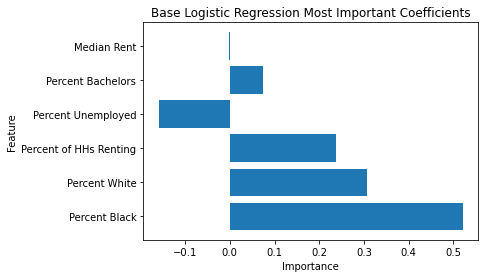



Model:  base_up_log_reg
The 1st most important element is Percent Black:                   0.5061*** (0.005)
The 2nd most important element is Percent White:                   0.3219*** (0.005)
The 3rd most important element is Percent of HHs Renting:                   0.2003*** (0.004)
The 4th most important element is Percent Unemployed:                   -0.1616*** (0.003)
The 5th most important element is Median Rent:                   0.0139*** (0.004)
The 6th most important element is Percent Bachelors:                   0.013*** (0.004)


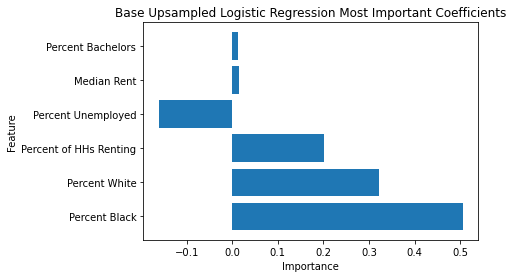



Model:  nontwitter_up_log_reg
The 1st most important element is Felonies PC 06-10:                   2.0353*** (0.013)
The 2nd most important element is Crime PC 06-10:                   -1.5447*** (0.012)
The 3rd most important element is Noise Reports Trend 11-13:                   0.5824*** (0.008)
The 4th most important element is Percent Black:                   0.5*** (0.005)
The 5th most important element is Felonies PC 11-13:                   -0.4371*** (0.012)
The 6th most important element is Crime Trendline 06-10:                   0.3918*** (0.006)
The 7th most important element is Crime PC 11-13:                   -0.3438*** (0.015)
The 8th most important element is Felony Trendline 06-10:                   -0.2826*** (0.005)
The 9th most important element is Trend in ST Vacant Commercial Addresses:                   -0.2711*** (0.005)
The 10th most important element is Percent White:                   0.2515*** (0.005)


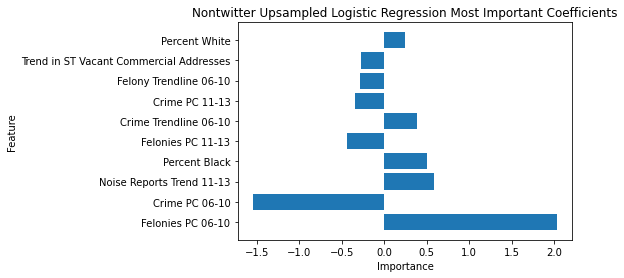



Model:  twitter_log_reg
The 1st most important element is Topic 3 Distribution: 2011-12:                   0.3079*** (0.002)
The 2nd most important element is Topic 3 Distribution: 2013-05:                   0.2403*** (0.003)
The 3rd most important element is Topic 18 Distribution: 2012-07:                   0.2227*** (0.002)
The 4th most important element is Topic 16 Distribution: 2013-01:                   0.2214*** (0.002)
The 5th most important element is Noise Reports Trend 11-13:                   0.2121*** (0.001)
The 6th most important element is Topic 39 Distribution: 2013-07:                   -0.2028*** (0.001)
The 7th most important element is Topic 22 Distribution: 2013-11:                   0.1982*** (0.002)
The 8th most important element is Topic 25 Distribution: 2012-04:                   0.1936*** (0.002)
The 9th most important element is Topic 17 Distribution: 2013-08:                   -0.1854*** (0.001)
The 10th most important element is Topic 22 Distribution: 201

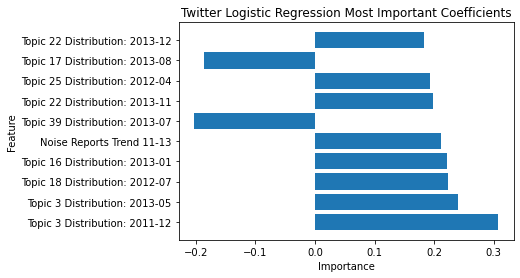



Model:  twitter_up_log_reg
The 1st most important element is Topic 3 Distribution: 2011-12:                   0.2963*** (0.002)
The 2nd most important element is Topic 39 Distribution: 2013-07:                   -0.23*** (0.002)
The 3rd most important element is Topic 3 Distribution: 2013-05:                   0.2191*** (0.003)
The 4th most important element is Topic 16 Distribution: 2013-01:                   0.2146*** (0.002)
The 5th most important element is Topic 18 Distribution: 2012-07:                   0.2085*** (0.003)
The 6th most important element is Topic 14 Distribution: 2013-06:                   -0.2052*** (0.001)
The 7th most important element is Topic 17 Distribution: 2013-08:                   -0.2047*** (0.001)
The 8th most important element is Topic 25 Distribution: 2012-04:                   0.2036*** (0.002)
The 9th most important element is Noise Reports Trend 11-13:                   0.1998*** (0.002)
The 10th most important element is Topic 22 Distribution: 2

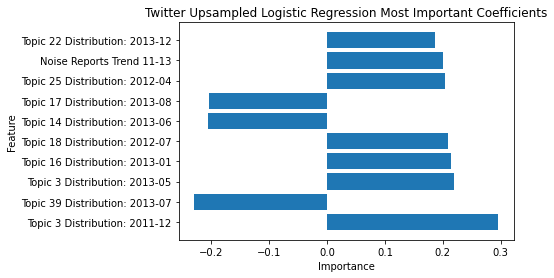



Model:  twitter_only_up_log_reg
The 1st most important element is Topic 3 Distribution: 2011-12:                   0.3025*** (0.002)
The 2nd most important element is Topic 39 Distribution: 2013-07:                   -0.2499*** (0.002)
The 3rd most important element is Topic 3 Distribution: 2013-05:                   0.2325*** (0.003)
The 4th most important element is Topic 18 Distribution: 2012-07:                   0.2173*** (0.003)
The 5th most important element is Topic 16 Distribution: 2013-01:                   0.2149*** (0.002)
The 6th most important element is Topic 17 Distribution: 2013-08:                   -0.2105*** (0.002)
The 7th most important element is Topic 14 Distribution: 2013-06:                   -0.2054*** (0.001)
The 8th most important element is Topic 25 Distribution: 2012-04:                   0.1974*** (0.002)
The 9th most important element is Topic 22 Distribution: 2013-12:                   0.1912*** (0.002)
The 10th most important element is Topic 39 Dis

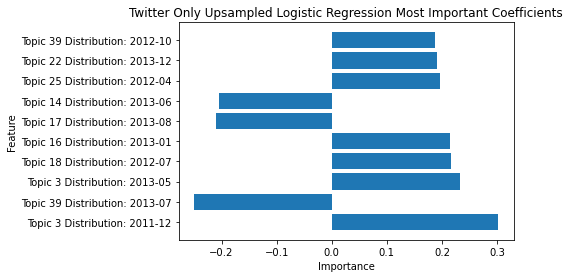

In [373]:
# Find most important features
log_top_features_base = find_top_features_log('base_log_reg', list_of_base_features_names, 'Base', 'base_log_reg', x=10)
log_top_features_base_up = find_top_features_log('base_up_log_reg', list_of_base_features_names, 'Base Upsampled', 'base_up_log_reg', x=10)
log_top_features_nontwitter_up = find_top_features_log('nontwitter_up_log_reg', list_of_nontwitter_features_names, 'Nontwitter Upsampled', 'nontwitter_up_log_reg', x=10)
log_top_features_twitter = find_top_features_log('twitter_log_reg', list_of_twitter_features_names, 'Twitter', 'twitter_log_reg', x=10)
log_top_features_twitter_up = find_top_features_log('twitter_up_log_reg', list_of_twitter_features_names, 'Twitter Upsampled', 'twitter_up_log_reg', x=10)
log_top_features_twitter_only_up = find_top_features_log('twitter_only_up_log_reg', twitter_only_features_names, 'Twitter Only Upsampled', 'twitter_only_up_log_reg', x=10)

Model:  base_rand_for
The 1st most important element is Percent Black:                   0.1834*** (0.0)
The 2nd most important element is Percent Bachelors:                   0.1756*** (0.0)
The 3rd most important element is Percent of HHs Renting:                   0.1676*** (0.0)
The 4th most important element is Percent Unemployed:                   0.1604*** (0.0)
The 5th most important element is Median Rent:                   0.158*** (0.0)
The 6th most important element is Percent White:                   0.1552*** (0.0)


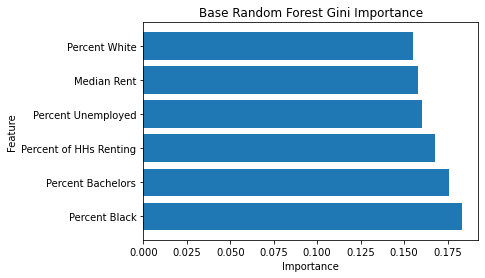



Model:  base_up_rand_for
The 1st most important element is Percent Black:                   0.1829*** (0.0)
The 2nd most important element is Percent of HHs Renting:                   0.1726*** (0.001)
The 3rd most important element is Percent Unemployed:                   0.1684*** (0.001)
The 4th most important element is Median Rent:                   0.1623*** (0.001)
The 5th most important element is Percent White:                   0.1608*** (0.0)
The 6th most important element is Percent Bachelors:                   0.1531*** (0.0)


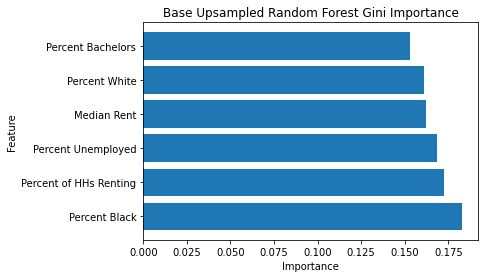



Model:  nontwitter_up_rand_for
The 1st most important element is Noise Reports Trend 11-13:                   0.0711*** (0.0)
The 2nd most important element is Trend in Residential Addresses:                   0.0631*** (0.0)
The 3rd most important element is Percent Black:                   0.0562*** (0.0)
The 4th most important element is Crime PC 11-13:                   0.05*** (0.0)
The 5th most important element is Felonies PC 06-10:                   0.0476*** (0.0)
The 6th most important element is Percent Unemployed:                   0.0474*** (0.0)
The 7th most important element is Median Rent:                   0.0463*** (0.0)
The 8th most important element is Felonies PC 11-13:                   0.0463*** (0.0)
The 9th most important element is Percent of HHs Renting:                   0.0461*** (0.0)
The 10th most important element is Crime Trendline 11-13:                   0.046*** (0.0)
The 11th most important element is Percent Bachelors:                   0.0442***

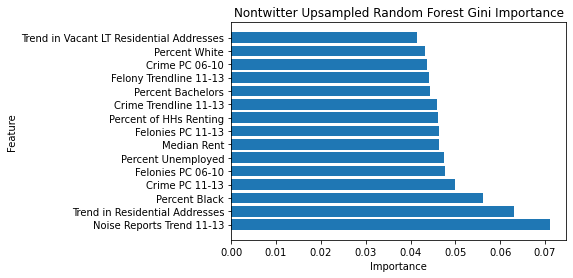



Model:  twitter_rand_for
The 1st most important element is Topic 3 Distribution: 2013-05:                   0.0033*** (0.0)
The 2nd most important element is Topic 7 Distribution: 2013-07:                   0.0033*** (0.0)
The 3rd most important element is Topic 2 Distribution: 2013-12:                   0.0032*** (0.0)
The 4th most important element is Topic 22 Distribution: 2013-12:                   0.0031*** (0.0)
The 5th most important element is Topic 3 Distribution: 2011-12:                   0.003*** (0.0)
The 6th most important element is Topic 21 Distribution: 2013-06:                   0.0029*** (0.0)
The 7th most important element is Topic 16 Distribution: 2013-01:                   0.0027*** (0.0)
The 8th most important element is Topic 10 Distribution: 2012-12:                   0.0026*** (0.0)
The 9th most important element is Topic 18 Distribution: 2011-06:                   0.0026*** (0.0)
The 10th most important element is Topic 6 Distribution: 2013-09:             

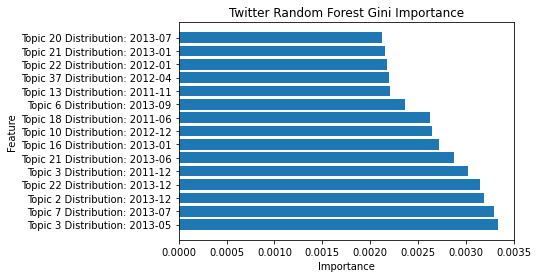



Model:  twitter_up_rand_for
The 1st most important element is Topic 6 Distribution: 2013-09:                   0.0037*** (0.0)
The 2nd most important element is Topic 22 Distribution: 2013-12:                   0.0036*** (0.0)
The 3rd most important element is Topic 7 Distribution: 2013-07:                   0.0034*** (0.0)
The 4th most important element is Topic 20 Distribution: 2013-07:                   0.0033*** (0.0)
The 5th most important element is Topic 3 Distribution: 2012-07:                   0.0032*** (0.0)
The 6th most important element is Topic 1 Distribution: 2013-06:                   0.0031*** (0.0)
The 7th most important element is Topic 11 Distribution: 2013-09:                   0.0031*** (0.0)
The 8th most important element is Topic 2 Distribution: 2013-12:                   0.0028*** (0.0)
The 9th most important element is Topic 3 Distribution: 2013-05:                   0.0027*** (0.0)
The 10th most important element is Topic 35 Distribution: 2013-07:          

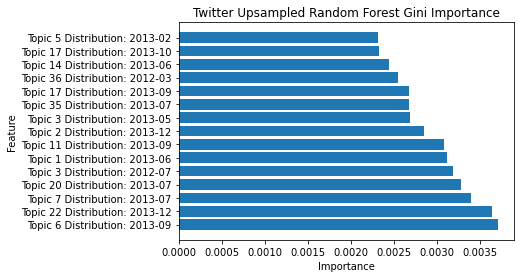



Model:  twitter_only_up_rand_for
The 1st most important element is Topic 20 Distribution: 2013-07:                   0.005*** (0.0)
The 2nd most important element is Topic 22 Distribution: 2013-12:                   0.0046*** (0.0)
The 3rd most important element is Topic 11 Distribution: 2013-09:                   0.0036*** (0.0)
The 4th most important element is Topic 7 Distribution: 2013-07:                   0.0035*** (0.0)
The 5th most important element is Topic 3 Distribution: 2013-05:                   0.0034*** (0.0)
The 6th most important element is Topic 6 Distribution: 2013-09:                   0.0034*** (0.0)
The 7th most important element is Topic 35 Distribution: 2013-07:                   0.003*** (0.0)
The 8th most important element is Topic 14 Distribution: 2013-06:                   0.0029*** (0.0)
The 9th most important element is Topic 17 Distribution: 2013-09:                   0.0029*** (0.0)
The 10th most important element is Topic 5 Distribution: 2013-02:     

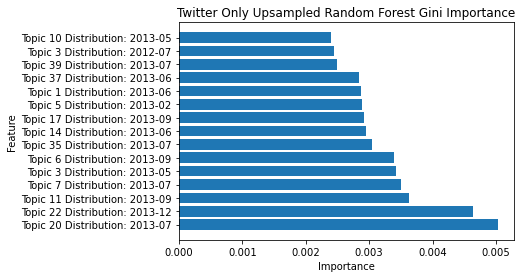

In [376]:
# Find most important features
rand_top_features_base = find_top_features_rand('base_rand_for', list_of_base_features_names, 'Base', 'base_rand_for', x=6)
rand_top_features_base_up = find_top_features_rand('base_up_rand_for', list_of_base_features_names, 'Base Upsampled','base_up_rand_for', x=6)
rand_top_features_nontwitter_up = find_top_features_rand('nontwitter_up_rand_for', list_of_nontwitter_features_names, 'Nontwitter Upsampled', 'nontwitter_up_rand_for', x=15)
rand_top_features_twitter = find_top_features_rand('twitter_rand_for', list_of_twitter_features_names, 'Twitter','twitter_rand_for', x=15)
rand_top_features_twitter_up = find_top_features_rand('twitter_up_rand_for', list_of_twitter_features_names,'Twitter Upsampled', 'twitter_up_rand_for', x=15)
rand_top_features_twitter_only_up = find_top_features_rand('twitter_only_up_rand_for', twitter_only_features_names,'Twitter Only Upsampled', 'twitter_only_up_rand_for', x=15)

In [297]:
ml_model_results.keys()

dict_keys(['base_log_reg', 'base_rand_for', 'base_up_log_reg', 'base_up_rand_for', 'nontwitter_up_log_reg', 'nontwitter_up_rand_for', 'twitter_log_reg', 'twitter_rand_for', 'twitter_up_log_reg', 'twitter_up_rand_for', 'twitter_only_up_log_reg', 'twitter_only_up_rand_for'])

In [ ]:
# Repeat models with alternate measure of gentrification
tune_ml(train_df_base_alt, train_df_upsampled_base_alt, test_df_base_alt, val_df_base_alt, train_labels_alt, train_labels_alt_upsampled, test_labels_alt, val_labels_alt)

In [ ]:
tune_ml(train_df_nontwitter_alt, train_df_upsampled_nontwitter_alt, test_df_nontwitter_alt, 
        val_df_nontwitter_alt, train_labels_alt, train_labels_alt_upsampled, test_labels_alt, val_labels_alt)

In [ ]:
tune_ml(train_df_twitter_alt, train_df_upsampled_twitter_alt, test_df_twitter_alt, val_df_twitter_alt, train_labels_alt, 
        train_labels_alt_upsampled, test_labels_alt, val_labels_alt)

In [ ]:
tune_ml(train_df_twitter_only_alt, train_df_upsampled_twitter_only_alt, test_df_twitter_only_alt, 
        val_df_twitter_only_alt, train_labels_alt, 
        train_labels_alt_upsampled, test_labels_alt, val_labels_alt)